In [ ]:
# 1. KÜTÜPHANELERI YÜKLE
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn.preprocessing import label_binarize

print("✅ Kütüphaneler yüklendi")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ Kütüphaneler yüklendi
TensorFlow: 2.19.0
GPU: True


In [ ]:
from google.colab import drive
import shutil
import os # 'os' modülü eklendi

# Drive bağla
print("🔗 Google Drive bağlanıyor...\n")
drive.mount('/content/drive', force_remount=True)

print("✅ Drive bağlandı!\n")

# Veri seti yolu
my_drive = "/content/drive/MyDrive"
dataset_path = os.path.join(my_drive, "CRCCD_V1 (Colorectal Cancer Classification and Detection)", "CRCCD_V1")

train_dir = os.path.join(dataset_path, "Train")
test_dir = os.path.join(dataset_path, "Test")

# Sınıfları al
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"✅ Veri Seti Yolu: {dataset_path}\n")
print(f"📊 SINIF BİLGİLERİ")
print(f"Toplam Sınıf: {num_classes}\n")
print(f"Sınıflar:")
for idx, cls in enumerate(classes, 1):
    print(f"  {idx}. {cls}")

# Veri istatistikleri
total_train = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes)
total_test = sum(len(os.listdir(os.path.join(test_dir, cls))) for cls in classes)

print(f"\n📈 VERİ SETİ İSTATİSTİKLERİ")
print(f"TRAIN: {total_train} görüntü")
print(f"TEST: {total_test} görüntü")
print(f"TOPLAM: {total_train + total_test} görüntü")

🔗 Google Drive bağlanıyor...

Mounted at /content/drive
✅ Drive bağlandı!

✅ Veri Seti Yolu: /content/drive/MyDrive/CRCCD_V1 (Colorectal Cancer Classification and Detection)/CRCCD_V1

📊 SINIF BİLGİLERİ
Toplam Sınıf: 14

Sınıflar:
  1. ASCENDINGCOLON_ADENOCARCINOMA
  2. CASIGMOID_COLON
  3. CECUM
  4. COLONADENOCARCINOMA
  5. ESOPHAGITIS
  6. HEMORRHOID_suspected_CA_colon
  7. ILEOCECAL_GROWTH
  8. POLYPS
  9. PYLORUS
  10. RECTADENOCARCINOMA
  11. RECTGROWTH
  12. SQUAMUS_CELL_ANAL_CARCINOMA
  13. ULCERATIVE_COLITIS
  14. Z_LINE

📈 VERİ SETİ İSTATİSTİKLERİ
TRAIN: 7000 görüntü
TEST: 1750 görüntü
TOPLAM: 8750 görüntü


In [ ]:
# 0 OVERFITTING İÇİN OPTIMIZE EDİLMİŞ VERİ GENERATOR
IMG_SIZE = 224
BATCH_SIZE = 16  # 64 yerine 16 (daha iyi öğrenme)
VALIDATION_SPLIT = 0.15

# GÜÇLÜ DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,        # 40 yerine 50
    width_shift_range=0.4,    # 0.3 yerine 0.4
    height_shift_range=0.4,   # 0.3 yerine 0.4
    shear_range=0.3,          # 0.2 yerine 0.3
    zoom_range=0.4,           # 0.3 yerine 0.4
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # YENİ: Parlaklık
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ 0 OVERFITTING İÇİN OPTIMIZE GENERATOR")
print(f"   - Batch Size: {BATCH_SIZE} (küçük)")
print(f"   - Rotation: ±50°")
print(f"   - Zoom: ±40%")
print(f"   - Shift: ±40%")
print(f"   - Brightness: YENİ!")

# DATA GENERATORS OLUŞTUR
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ TRAIN Batch: {len(train_generator)}")
print(f"✅ VALIDATION Batch: {len(val_generator)}")
print(f"✅ TEST Batch: {len(test_generator)}")

✅ 0 OVERFITTING İÇİN OPTIMIZE GENERATOR
   - Batch Size: 16 (küçük)
   - Rotation: ±50°
   - Zoom: ±40%
   - Shift: ±40%
   - Brightness: YENİ!
Found 5950 images belonging to 14 classes.
Found 1050 images belonging to 14 classes.
Found 1750 images belonging to 14 classes.

✅ TRAIN Batch: 372
✅ VALIDATION Batch: 66
✅ TEST Batch: 110


In [ ]:
# CALLBACK'LER (Overfitting'i Önle)
def get_callbacks(model_name):
    """Eğitim sırasında kullanılacak callback'ler"""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=15,  # 15 epoch sabır
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'/content/best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        )
    ]

print("✅ Callback'ler tanımlandı (Overfitting önleme)")

✅ Callback'ler tanımlandı (Overfitting önleme)


In [ ]:
# 1. VGG16 TRANSFER LEARNING MODELİ
def create_vgg16_optimized():
    """VGG16 - Transfer Learning (Fine-tuning ile - OVERFITTING AZALTILDI)"""

    # ImageNet ağırlıklarıyla başla
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # DEĞIŞEN: Son 7 katman → Son 3 katman (daha az eğitim)
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    # Model oluştur
    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),

        # Dense Layers (GÜÇLÜ OVERFITTING ÖNLEME)
        # DEĞIŞEN: 512 → 256, L2: 0.001 → 0.05, Dropout: 0.5 → 0.7
        Dense(256, kernel_regularizer=l2(0.05)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.7),  # %50 → %70 dropout

        # DEĞIŞEN: 256 → 128, L2: 0.001 → 0.05, Dropout: 0.4 → 0.6
        Dense(128, kernel_regularizer=l2(0.05)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.6),  # %40 → %60 dropout

        # DEĞIŞEN: L2: 0.001 → 0.05, Dropout: 0.3 → 0.5
        Dense(64, kernel_regularizer=l2(0.05)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),  # %30 → %50 dropout

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    return model

print("✅ VGG16 Modeli Tanımlandı (DÜZELTİLMİŞ)")
print("   - Fine-tuning: Son 3 katman eğitilecek (DÜŞÜRÜLDÜ)")
print("   - Dropout: %70, %60, %50 (ARTIRILDI)")
print("   - L2 Regularization: 0.05 (ARTIRILDI)")
print("   - Batch Normalization: Evet")
print("   - AMAÇ: Overfitting 14.72% → 5% altına düşür")

✅ VGG16 Modeli Tanımlandı (DÜZELTİLMİŞ)
   - Fine-tuning: Son 3 katman eğitilecek (DÜŞÜRÜLDÜ)
   - Dropout: %70, %60, %50 (ARTIRILDI)
   - L2 Regularization: 0.05 (ARTIRILDI)
   - Batch Normalization: Evet
   - AMAÇ: Overfitting 14.72% → 5% altına düşür


In [ ]:
# ===========================================
# MODEL1 VGG16
# ===========================================
print("="*80)
print("VGG16 FIXED MODEL EĞİTİLİYOR...")
print("="*80 + "\n")

def create_vgg16_fixed():
    base_model = keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # SON 3 KATMAN FINE-TUNE
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.6),

        Dense(128, kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    return model

# MODEL OLUŞTUR
vgg16_fixed = create_vgg16_fixed()

# COMPILE
vgg16_fixed.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EĞİTİM
print("⏳ VGG16 FIXED eğitimi başlıyor...\n")
history = vgg16_fixed.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=get_callbacks('VGG16_Fixed'),
    verbose=1
)

# KAYDET
vgg16_fixed.save('/content/drive/MyDrive/CRCCD_Models/VGG16_Fixed.h5')

# TEST
test_pred = vgg16_fixed.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

# SONUÇLAR
final_train = history.history['accuracy'][-1]
final_val = history.history['val_accuracy'][-1]
overfitting_gap = (final_train - final_val) * 100

print(f"\n✅ VGG16 FIXED Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {overfitting_gap:.2f}%")

VGG16 FIXED MODEL EĞİTİLİYOR...

⏳ VGG16 FIXED eğitimi başlıyor...

Epoch 1/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.1050 - loss: 7.2015

372/372 ━━━━━━━━━━━━━━━━━━━━ 148s 382ms/step - accuracy: 0.1050 - loss: 7.2009 - val_accuracy: 0.2543 - val_loss: 6.2181 - learning_rate: 3.0000e-05
Epoch 2/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.1778 - loss: 6.4857

372/372 ━━━━━━━━━━━━━━━━━━━━ 136s 366ms/step - accuracy: 0.1779 - loss: 6.4853 - val_accuracy: 0.3362 - val_loss: 5.6404 - learning_rate: 3.0000e-05
Epoch 3/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2289 - loss: 6.0404

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 363ms/step - accuracy: 0.2289 - loss: 6.0401 - val_accuracy: 0.3924 - val_loss: 5.3119 - learning_rate: 3.0000e-05
Epoch 4/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2643 - loss: 5.6562

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 363ms/step - accuracy: 0.2644 - loss: 5.6559 - val_accuracy: 0.4076 - val_loss: 4.9826 - learning_rate: 3.0000e-05
Epoch 5/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3044 - loss: 5.3381

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 363ms/step - accuracy: 0.3044 - loss: 5.3379 - val_accuracy: 0.4352 - val_loss: 4.6878 - learning_rate: 3.0000e-05
Epoch 6/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3295 - loss: 5.0648

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.3296 - loss: 5.0646 - val_accuracy: 0.4600 - val_loss: 4.4694 - learning_rate: 3.0000e-05
Epoch 7/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.3531 - loss: 4.8316

372/372 ━━━━━━━━━━━━━━━━━━━━ 136s 365ms/step - accuracy: 0.3531 - loss: 4.8315 - val_accuracy: 0.4790 - val_loss: 4.3074 - learning_rate: 3.0000e-05
Epoch 8/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.3757 - loss: 4.6250 - val_accuracy: 0.4410 - val_loss: 4.2043 - learning_rate: 3.0000e-05
Epoch 9/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.4043 - loss: 4.4050

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.4043 - loss: 4.4049 - val_accuracy: 0.5229 - val_loss: 3.9476 - learning_rate: 3.0000e-05
Epoch 10/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.4241 - loss: 4.2218

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.4241 - loss: 4.2217 - val_accuracy: 0.5286 - val_loss: 3.8002 - learning_rate: 3.0000e-05
Epoch 11/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.4437 - loss: 4.0859 - val_accuracy: 0.4971 - val_loss: 3.7132 - learning_rate: 3.0000e-05
Epoch 12/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4648 - loss: 3.9272

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 362ms/step - accuracy: 0.4648 - loss: 3.9271 - val_accuracy: 0.5381 - val_loss: 3.6204 - learning_rate: 3.0000e-05
Epoch 13/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4686 - loss: 3.8041

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 359ms/step - accuracy: 0.4686 - loss: 3.8040 - val_accuracy: 0.5524 - val_loss: 3.4588 - learning_rate: 3.0000e-05
Epoch 14/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.4932 - loss: 3.6506

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.4932 - loss: 3.6506 - val_accuracy: 0.5533 - val_loss: 3.4074 - learning_rate: 3.0000e-05
Epoch 15/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5168 - loss: 3.5456

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 363ms/step - accuracy: 0.5168 - loss: 3.5455 - val_accuracy: 0.5981 - val_loss: 3.2431 - learning_rate: 3.0000e-05
Epoch 16/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.5329 - loss: 3.4077 - val_accuracy: 0.5867 - val_loss: 3.1886 - learning_rate: 3.0000e-05
Epoch 17/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.5300 - loss: 3.3472 - val_accuracy: 0.5924 - val_loss: 3.0961 - learning_rate: 3.0000e-05
Epoch 18/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5492 - loss: 3.2501

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - accuracy: 0.5493 - loss: 3.2500 - val_accuracy: 0.6000 - val_loss: 3.0361 - learning_rate: 3.0000e-05
Epoch 19/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5652 - loss: 3.1215

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.5653 - loss: 3.1215 - val_accuracy: 0.6505 - val_loss: 2.9166 - learning_rate: 3.0000e-05
Epoch 20/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.5860 - loss: 3.0350 - val_accuracy: 0.6390 - val_loss: 2.8356 - learning_rate: 3.0000e-05
Epoch 21/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.5806 - loss: 2.9891 - val_accuracy: 0.6190 - val_loss: 2.8072 - learning_rate: 3.0000e-05
Epoch 22/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.6099 - loss: 2.8723 - val_accuracy: 0.6105 - val_loss: 2.7620 - learning_rate: 3.0000e-05
Epoch 23/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 356ms/step - accuracy: 0.6305 - loss: 2.7596 - val_accuracy: 0.6343 - val_loss: 2.6827 - learning_rate: 3.0000e-05
Epoch 24/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 364ms/step - accuracy: 0.6004 - loss: 2.7904 - val_accuracy: 0.6152 - val_loss: 2.6472 - learning_rate: 3.0000e-05
Epoch 25/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step

✅ VGG16 FIXED Tamamlandı!
  Train: 64.54%
  Val:   65.05%
  Test:  77.54%
  Gap:   -0.51%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step


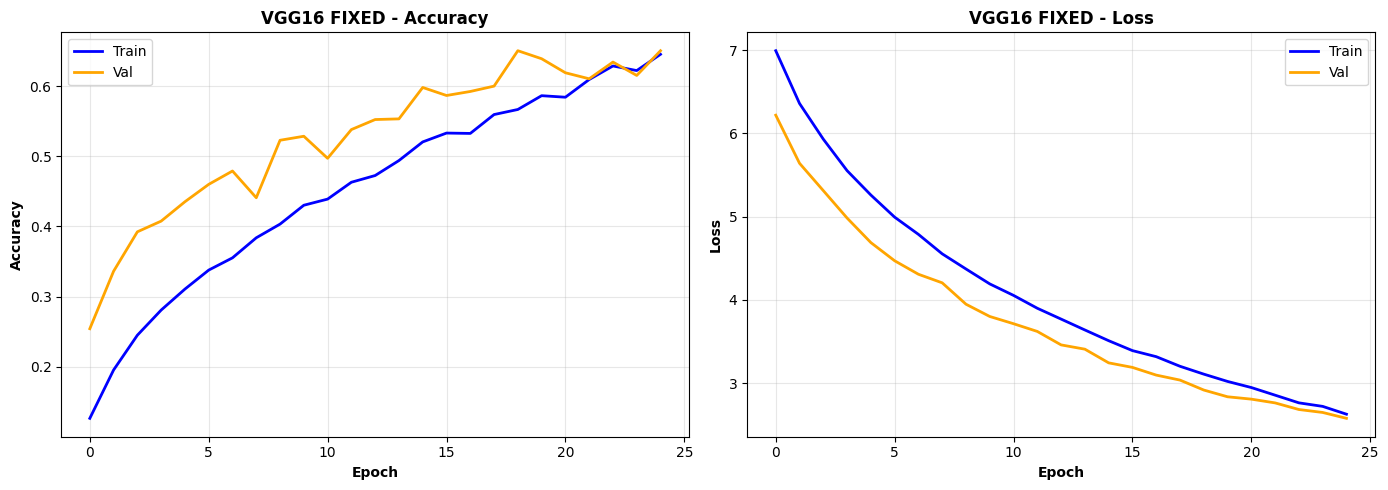

✅ Training Curves Kaydedildi!


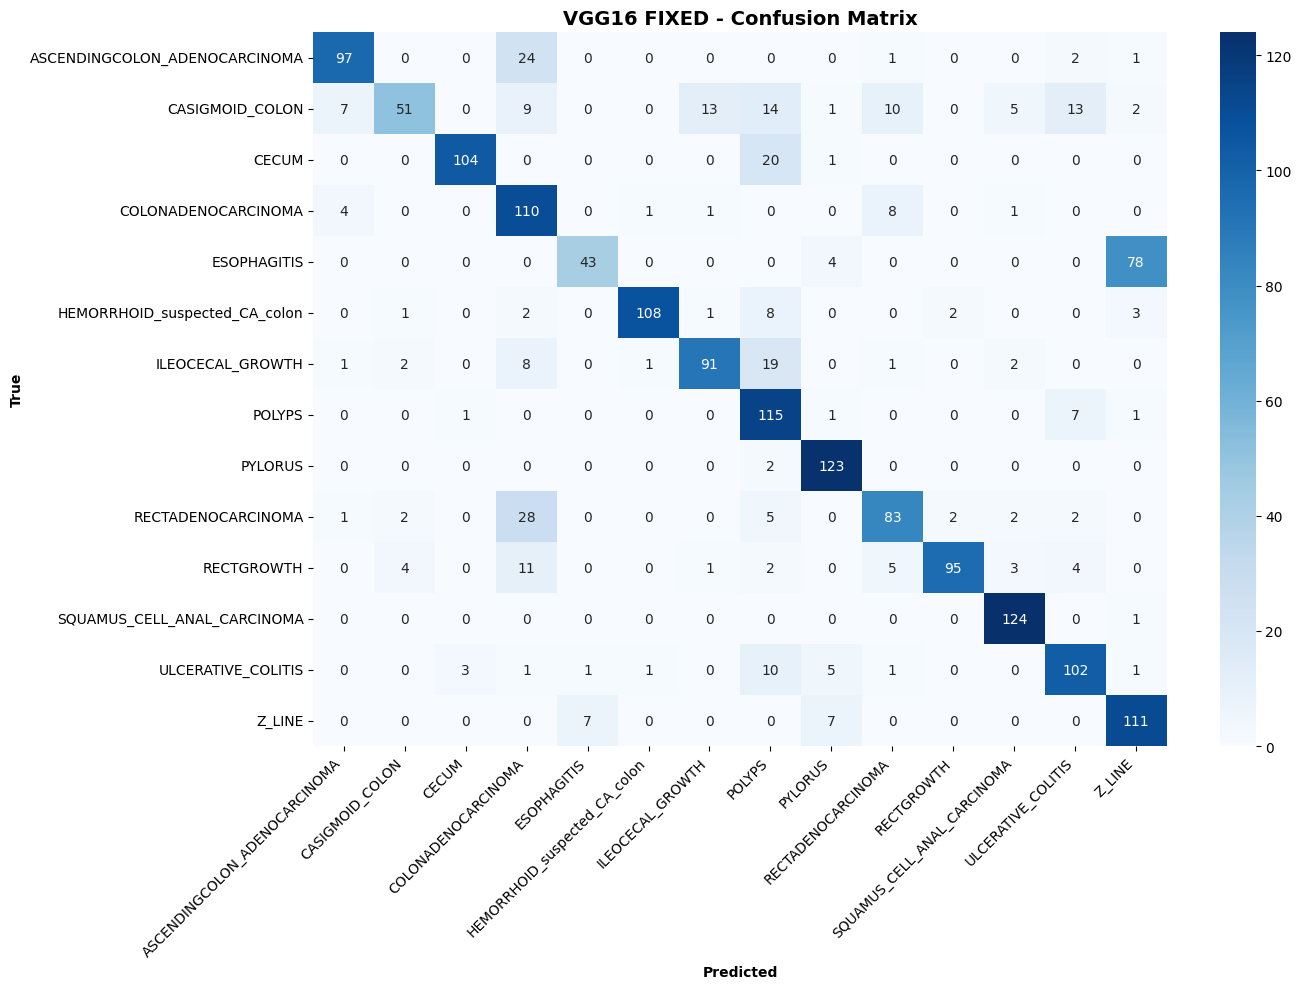

✅ Confusion Matrix Kaydedildi!


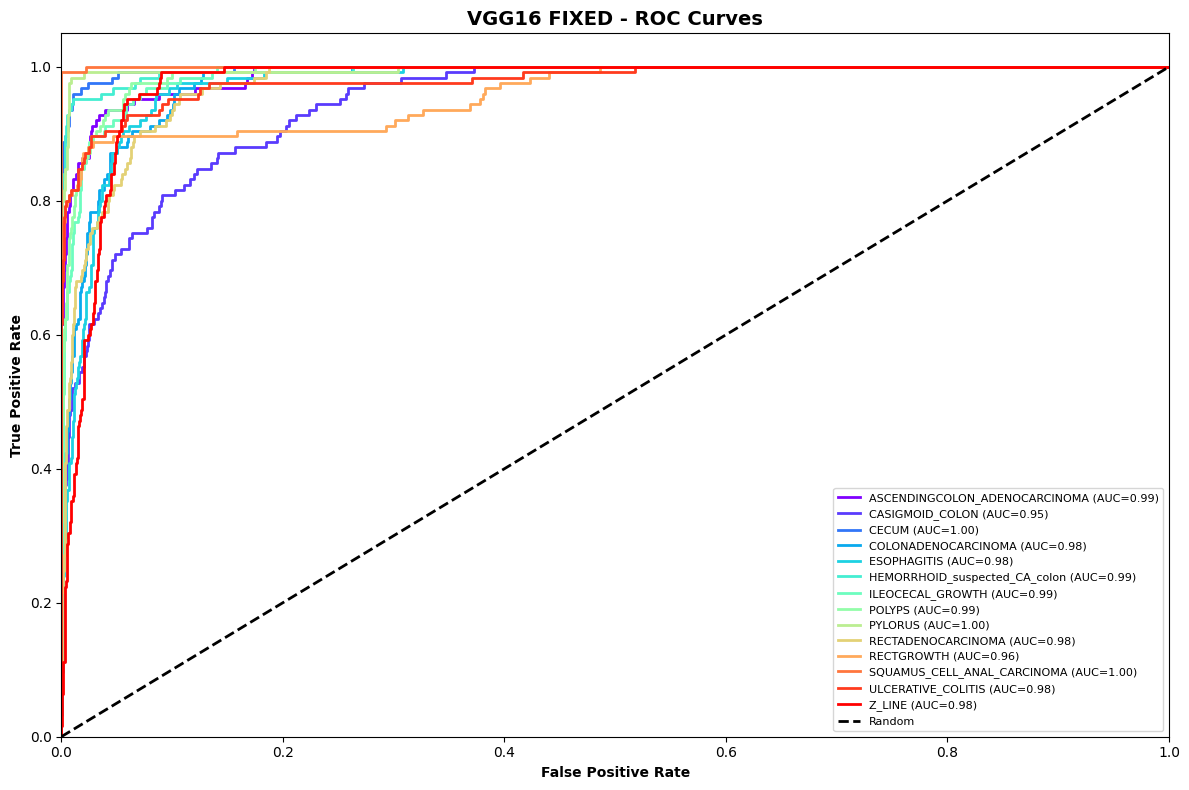

✅ ROC Eğrisi Kaydedildi!

📊 VGG16 FIXED METRİKLERİ:
  Test Accuracy: 77.54%
  Precision: 81.13%
  Recall: 77.54%
  F1-Score: 77.01%
  Cohen Kappa: 0.7582

📋 CLASSIFICATION REPORT:
                               precision    recall  f1-score   support

ASCENDINGCOLON_ADENOCARCINOMA       0.88      0.78      0.83       125
              CASIGMOID_COLON       0.85      0.41      0.55       125
                        CECUM       0.96      0.83      0.89       125
          COLONADENOCARCINOMA       0.57      0.88      0.69       125
                  ESOPHAGITIS       0.84      0.34      0.49       125
HEMORRHOID_suspected_CA_colon       0.97      0.86      0.92       125
             ILEOCECAL_GROWTH       0.85      0.73      0.78       125
                       POLYPS       0.59      0.92      0.72       125
                      PYLORUS       0.87      0.98      0.92       125
           RECTADENOCARCINOMA       0.76      0.66      0.71       125
                   RECTGROWTH       0.

In [ ]:
# MODEL1 VGG16 - GRAFİKLER VE METRİKLER
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# TEST TAHMIN
test_pred = vgg16_fixed.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('VGG16 FIXED - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('VGG16 FIXED - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/VGG16_FIXED_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('VGG16 FIXED - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/VGG16_FIXED_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('VGG16 FIXED - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/VGG16_FIXED_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

# 4. METRİKLER
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report

precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n📊 VGG16 FIXED METRİKLERİ:")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Precision: {precision*100:.2f}%")
print(f"  Recall: {recall*100:.2f}%")
print(f"  F1-Score: {f1*100:.2f}%")
print(f"  Cohen Kappa: {kappa:.4f}")

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_true, test_pred_classes, target_names=classes))

print(f"\n✅ VGG16 FIXED Grafikleri Kaydedildi!")

In [ ]:
# ===========================================
# MOBILENETV2 - FIXED
# ===========================================
print("="*80)
print("MOBİLENETv2 FIXED MODEL EĞİTİLİYOR...")
print("="*80 + "\n")

def create_mobilenet_v2_fixed():
    base_model = keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # DOĞRU FINE-TUNE
    for layer in base_model.layers[:-50]:  # Son 50 katman eğit
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),

        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        Dense(num_classes, activation='softmax')
    ])

    return model

# MODEL OLUŞTUR
mobilenet_fixed = create_mobilenet_v2_fixed()

# COMPILE
mobilenet_fixed.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EĞİTİM
print("⏳ MOBİLENETv2 FIXED eğitimi başlıyor...\n")
history = mobilenet_fixed.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=get_callbacks('MobileNetV2_Fixed'),
    verbose=1
)

# KAYDET
mobilenet_fixed.save('/content/drive/MyDrive/CRCCD_Models/MobileNetV2_Fixed.h5')

# TEST
test_pred = mobilenet_fixed.predict(test_generator)
test_acc = np.sum(np.argmax(test_pred, axis=1) == test_generator.classes) / len(test_generator.classes)

# SONUÇLAR
final_train = history.history['accuracy'][-1]
final_val = history.history['val_accuracy'][-1]
overfitting_gap = (final_train - final_val) * 100

print(f"\n✅ MOBİLENETv2 FIXED Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {overfitting_gap:.2f}%")

MOBİLENETv2 FIXED MODEL EĞİTİLİYOR...

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
⏳ MOBİLENETv2 FIXED eğitimi başlıyor...

Epoch 1/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1149 - loss: 2.9591 

372/372 ━━━━━━━━━━━━━━━━━━━━ 5808s 15s/step - accuracy: 0.1150 - loss: 2.9583 - val_accuracy: 0.2467 - val_loss: 2.1733 - learning_rate: 5.0000e-05
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2929 - loss: 2.1416

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.2930 - loss: 2.1413 - val_accuracy: 0.3762 - val_loss: 1.7269 - learning_rate: 5.0000e-05
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4090 - loss: 1.7782

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.4090 - loss: 1.7781 - val_accuracy: 0.5305 - val_loss: 1.3973 - learning_rate: 5.0000e-05
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4739 - loss: 1.5625

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.4739 - loss: 1.5624 - val_accuracy: 0.5743 - val_loss: 1.2883 - learning_rate: 5.0000e-05
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5322 - loss: 1.3871

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.5322 - loss: 1.3870 - val_accuracy: 0.6067 - val_loss: 1.1300 - learning_rate: 5.0000e-05
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5724 - loss: 1.2963

372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.5724 - loss: 1.2961 - val_accuracy: 0.6429 - val_loss: 1.0398 - learning_rate: 5.0000e-05
Epoch 7/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6114 - loss: 1.1612

372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.6115 - loss: 1.1612 - val_accuracy: 0.6610 - val_loss: 0.9893 - learning_rate: 5.0000e-05
Epoch 8/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.6501 - loss: 1.0655 - val_accuracy: 0.6429 - val_loss: 1.0174 - learning_rate: 5.0000e-05
Epoch 9/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6858 - loss: 0.9698

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.6858 - loss: 0.9698 - val_accuracy: 0.6724 - val_loss: 0.9638 - learning_rate: 5.0000e-05
Epoch 10/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6936 - loss: 0.9536

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.6937 - loss: 0.9535 - val_accuracy: 0.6867 - val_loss: 0.8863 - learning_rate: 5.0000e-05
Epoch 11/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7253 - loss: 0.8671

372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.7253 - loss: 0.8671 - val_accuracy: 0.7076 - val_loss: 0.8469 - learning_rate: 5.0000e-05
Epoch 12/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7405 - loss: 0.7886

372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.7405 - loss: 0.7886 - val_accuracy: 0.7086 - val_loss: 0.8506 - learning_rate: 5.0000e-05
Epoch 13/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.7855 - loss: 0.7210 - val_accuracy: 0.6819 - val_loss: 0.8865 - learning_rate: 5.0000e-05
Epoch 14/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7772 - loss: 0.7115

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 351ms/step - accuracy: 0.7772 - loss: 0.7116 - val_accuracy: 0.7105 - val_loss: 0.7781 - learning_rate: 5.0000e-05
Epoch 15/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7933 - loss: 0.6605

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.7933 - loss: 0.6605 - val_accuracy: 0.7533 - val_loss: 0.7205 - learning_rate: 5.0000e-05
Epoch 16/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.7987 - loss: 0.6332 - val_accuracy: 0.7448 - val_loss: 0.7609 - learning_rate: 5.0000e-05
Epoch 17/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.8213 - loss: 0.6043 - val_accuracy: 0.7410 - val_loss: 0.7853 - learning_rate: 5.0000e-05
Epoch 18/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.8179 - loss: 0.5916 - val_accuracy: 0.7276 - val_loss: 0.7692 - learning_rate: 5.0000e-05
Epoch 19/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8316 - loss: 0.5599

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.8316 - loss: 0.5598 - val_accuracy: 0.7752 - val_loss: 0.6584 - learning_rate: 5.0000e-05
Epoch 20/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.8443 - loss: 0.5068 - val_accuracy: 0.7667 - val_loss: 0.6831 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 19.


110/110 ━━━━━━━━━━━━━━━━━━━━ 1453s 13s/step

✅ MOBİLENETv2 FIXED Tamamlandı!
  Train: 83.75%
  Val:   76.67%
  Test:  87.94%
  Gap:   7.08%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step


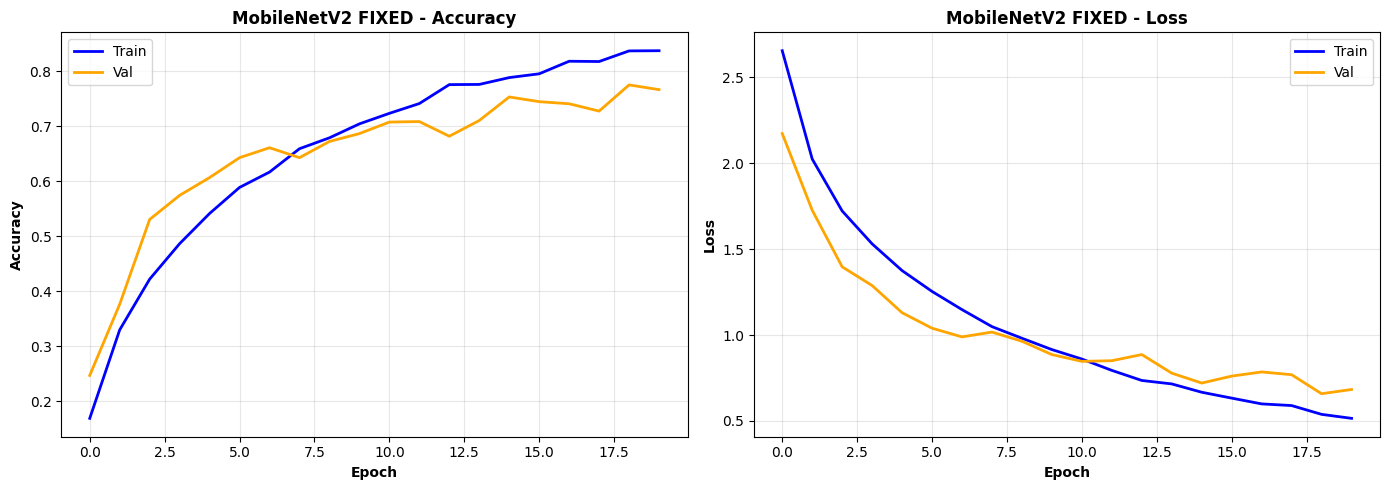

✅ Training Curves Kaydedildi!


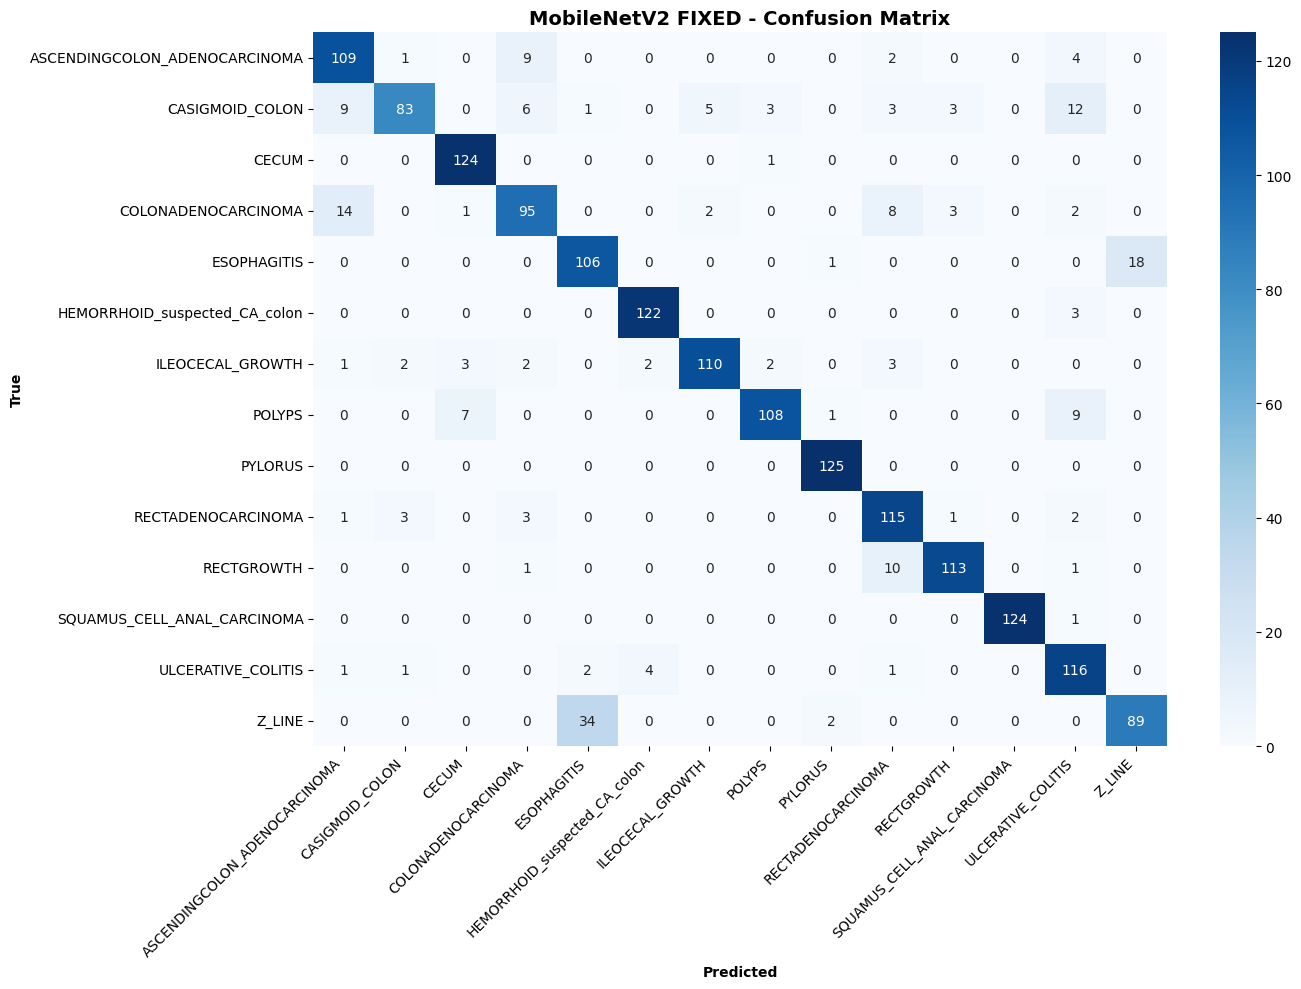

✅ Confusion Matrix Kaydedildi!


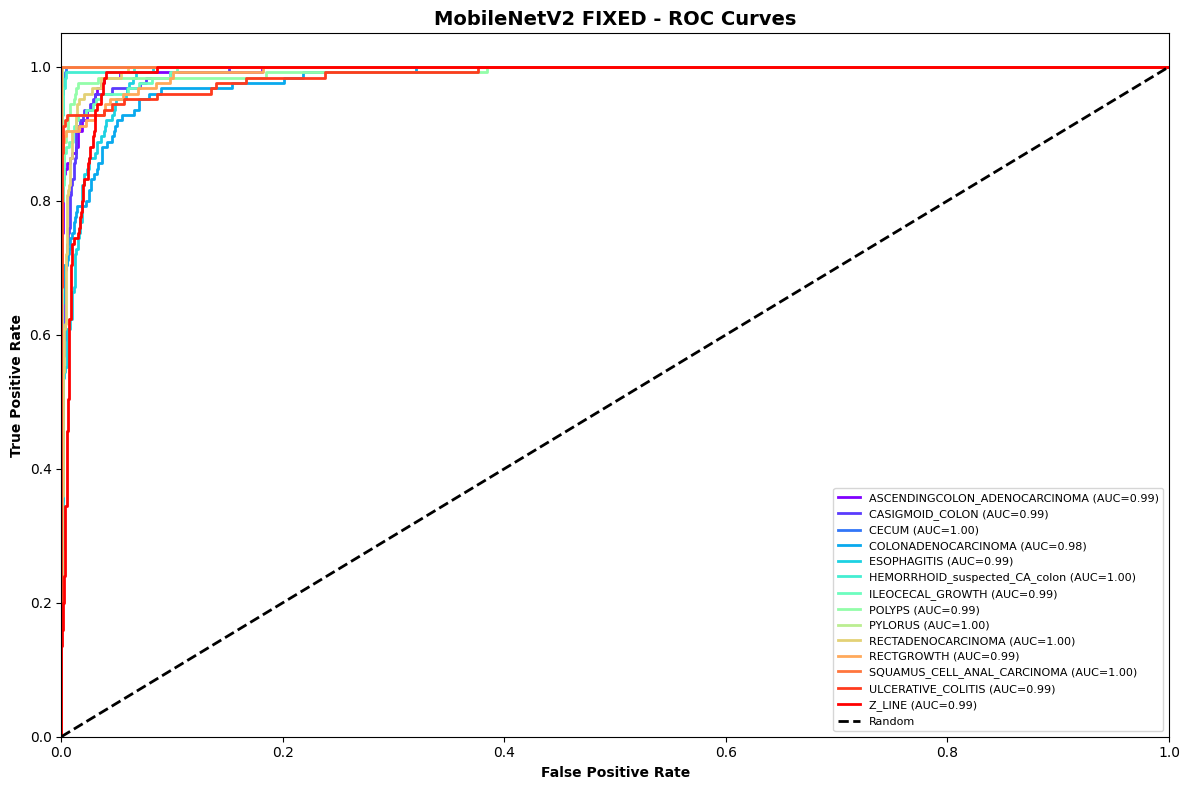

✅ ROC Eğrisi Kaydedildi!

📊 MOBİLENETv2 FIXED METRİKLERİ

📈 TRAIN - VAL - TEST - GAP:
----------------------------------------------------------------------
│ TRAIN:        83.75%
│ VAL:          76.67%
│ TEST:          87.94%
│ GAP:          7.08%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     88.39%
│ Recall:        87.94%
│ F1-Score:      87.83%
│ Cohen Kappa:  0.8702

📋 CLASSIFICATION REPORT:
                               precision    recall  f1-score   support

ASCENDINGCOLON_ADENOCARCINOMA       0.81      0.87      0.84       125
              CASIGMOID_COLON       0.92      0.66      0.77       125
                        CECUM       0.92      0.99      0.95       125
          COLONADENOCARCINOMA       0.82      0.76      0.79       125
                  ESOPHAGITIS       0.74      0.85      0.79       125
HEMORRHOID_suspected_CA_colon       0.95      0.98      0.96       125
             ILEOCECAL_GROWTH       0.9

In [ ]:
# MOBİLENETv2 FIXED - TÜM GRAFİKLER VE METRİKLER
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

# history'yi ata
mobilenet_history_fixed = history

# TEST TAHMIN
test_pred = mobilenet_fixed.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(mobilenet_history_fixed.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(mobilenet_history_fixed.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('MobileNetV2 FIXED - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(mobilenet_history_fixed.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(mobilenet_history_fixed.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('MobileNetV2 FIXED - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/MobileNetV2_FIXED_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('MobileNetV2 FIXED - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/MobileNetV2_FIXED_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('MobileNetV2 FIXED - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/MobileNetV2_FIXED_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

# 4. METRİKLER
precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 MOBİLENETv2 FIXED METRİKLERİ")
print("="*70)
print(f"\n📈 TRAIN - VAL - TEST - GAP:")
print("-" * 70)
print(f"│ TRAIN:        83.75%")
print(f"│ VAL:          76.67%")
print(f"│ TEST:         {test_accuracy*100:6.2f}%")
print(f"│ GAP:          7.08%")
print("-" * 70)

print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_true, test_pred_classes, target_names=classes))

print(f"\n✅ MOBİLENETv2 FIXED Grafikleri Tamamlandı!")

In [ ]:
# MODEL 3: INCEPTIONV3
print("="*80)
print("INCEPTIONV3 MODELİ EĞİTİLİYOR (0 OVERFITTING)...")
print("="*80 + "\n")

def create_inception_v3_optimized():
    base_model = keras.applications.InceptionV3(
        weights='imagenet', include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),

        # GÜÇLÜ REGULARIZATION
        Dense(512, kernel_regularizer=l2(0.01)),  # 0.001 yerine 0.01
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.6),  # 0.5 yerine 0.6

        Dense(256, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),  # 0.4 yerine 0.5

        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),  # 0.3 yerine 0.4

        Dense(num_classes, activation='softmax')
    ])
    return model

inception_model = create_inception_v3_optimized()
inception_model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

inception_history = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,  # 20 yerine 25 (daha iyi convergence)
    callbacks=get_callbacks('InceptionV3'),
    verbose=1
)

inception_model.save('/content/drive/MyDrive/CRCCD_Models/InceptionV3_optimized.h5')

test_pred = inception_model.predict(test_generator)
test_acc = np.sum(np.argmax(test_pred, axis=1) == test_generator.classes) / len(test_generator.classes)

final_train = inception_history.history['accuracy'][-1]
final_val = inception_history.history['val_accuracy'][-1]
overfitting_gap = (final_train - final_val) * 100

print(f"\n✅ INCEPTIONV3 Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Overfitting Gap: {overfitting_gap:.2f}%")

INCEPTIONV3 MODELİ EĞİTİLİYOR (0 OVERFITTING)...

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.1005 - loss: 16.2576

372/372 ━━━━━━━━━━━━━━━━━━━━ 202s 460ms/step - accuracy: 0.1006 - loss: 16.2569 - val_accuracy: 0.3381 - val_loss: 14.8662 - learning_rate: 5.0000e-05
Epoch 2/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.1792 - loss: 15.1172

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 359ms/step - accuracy: 0.1792 - loss: 15.1166 - val_accuracy: 0.4400 - val_loss: 13.8884 - learning_rate: 5.0000e-05
Epoch 3/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.2529 - loss: 14.1606

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.2529 - loss: 14.1600 - val_accuracy: 0.4743 - val_loss: 13.0522 - learning_rate: 5.0000e-05
Epoch 4/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3264 - loss: 13.2450

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.3265 - loss: 13.2445 - val_accuracy: 0.4990 - val_loss: 12.2523 - learning_rate: 5.0000e-05
Epoch 5/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3515 - loss: 12.4585

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.3515 - loss: 12.4579 - val_accuracy: 0.5400 - val_loss: 11.4363 - learning_rate: 5.0000e-05
Epoch 6/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4018 - loss: 11.6086

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.4018 - loss: 11.6080 - val_accuracy: 0.5695 - val_loss: 10.6460 - learning_rate: 5.0000e-05
Epoch 7/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4344 - loss: 10.8150

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.4344 - loss: 10.8144 - val_accuracy: 0.5800 - val_loss: 9.8952 - learning_rate: 5.0000e-05
Epoch 8/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4668 - loss: 10.0400

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 358ms/step - accuracy: 0.4668 - loss: 10.0394 - val_accuracy: 0.5971 - val_loss: 9.1668 - learning_rate: 5.0000e-05
Epoch 9/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.4938 - loss: 9.2633 - val_accuracy: 0.5933 - val_loss: 8.4809 - learning_rate: 5.0000e-05
Epoch 10/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5358 - loss: 8.5302

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 356ms/step - accuracy: 0.5359 - loss: 8.5297 - val_accuracy: 0.6143 - val_loss: 7.8236 - learning_rate: 5.0000e-05
Epoch 11/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5620 - loss: 7.8640

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 359ms/step - accuracy: 0.5621 - loss: 7.8635 - val_accuracy: 0.6410 - val_loss: 7.1827 - learning_rate: 5.0000e-05
Epoch 12/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.6124 - loss: 7.2086 - val_accuracy: 0.6410 - val_loss: 6.6503 - learning_rate: 5.0000e-05
Epoch 13/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6101 - loss: 6.6444

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.6101 - loss: 6.6441 - val_accuracy: 0.6419 - val_loss: 6.1503 - learning_rate: 5.0000e-05
Epoch 14/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6370 - loss: 6.1030

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.6370 - loss: 6.1027 - val_accuracy: 0.6638 - val_loss: 5.6117 - learning_rate: 5.0000e-05
Epoch 15/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6560 - loss: 5.6223

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.6560 - loss: 5.6219 - val_accuracy: 0.6752 - val_loss: 5.2080 - learning_rate: 5.0000e-05
Epoch 16/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.6849 - loss: 5.1379 - val_accuracy: 0.6743 - val_loss: 4.8223 - learning_rate: 5.0000e-05
Epoch 17/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6974 - loss: 4.7260

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.6974 - loss: 4.7258 - val_accuracy: 0.7019 - val_loss: 4.4534 - learning_rate: 5.0000e-05
Epoch 18/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.7125 - loss: 4.3968 - val_accuracy: 0.6914 - val_loss: 4.1526 - learning_rate: 5.0000e-05
Epoch 19/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.7223 - loss: 4.0300 - val_accuracy: 0.6648 - val_loss: 3.8815 - learning_rate: 5.0000e-05
Epoch 20/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.7484 - loss: 3.7114 - val_accuracy: 0.6990 - val_loss: 3.6083 - learning_rate: 5.0000e-05
Epoch 21/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.7546 - loss: 3.4708 - val_accuracy: 0.6981 - val_loss: 3.3874 - learning_rate: 5.0000e-05
Epoch 22/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7646 - loss: 3.2008

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.7646 - loss: 3.2006 - val_accuracy: 0.7171 - val_loss: 3.1192 - learning_rate: 5.0000e-05
Epoch 23/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.7698 - loss: 2.9968 - val_accuracy: 0.7086 - val_loss: 2.9927 - learning_rate: 5.0000e-05
Epoch 24/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.7798 - loss: 2.7971 - val_accuracy: 0.7010 - val_loss: 2.8567 - learning_rate: 5.0000e-05
Epoch 25/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7885 - loss: 2.6148

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.7885 - loss: 2.6147 - val_accuracy: 0.7343 - val_loss: 2.6620 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 25.


110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step

✅ INCEPTIONV3 Tamamlandı!
  Train: 78.64%
  Val:   73.43%
  Test:  88.34%
  Overfitting Gap: 5.21%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step


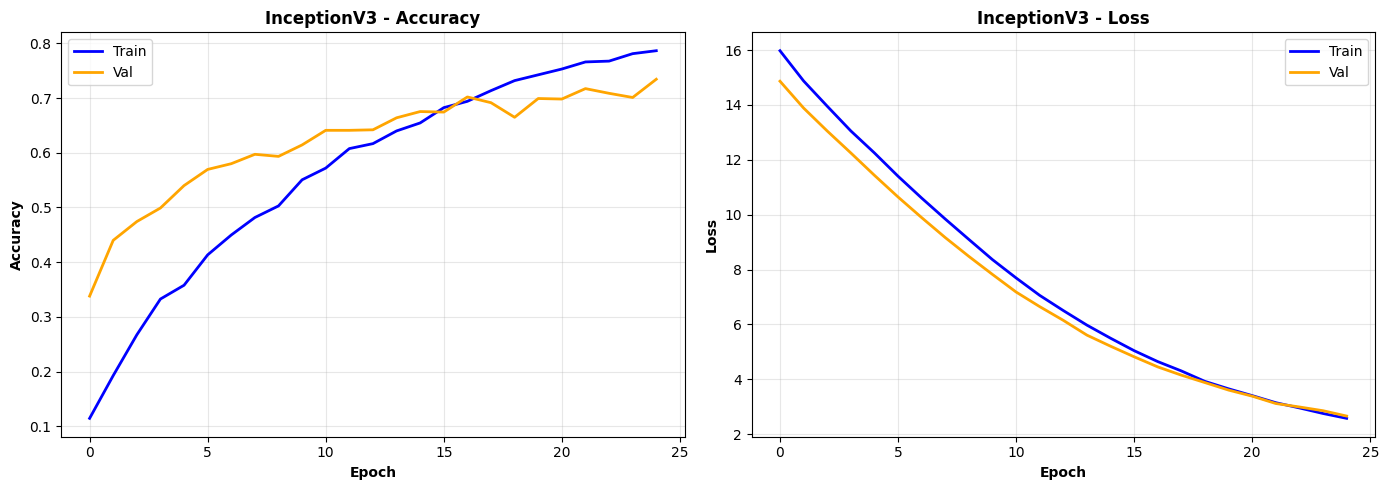

✅ Training Curves Kaydedildi!


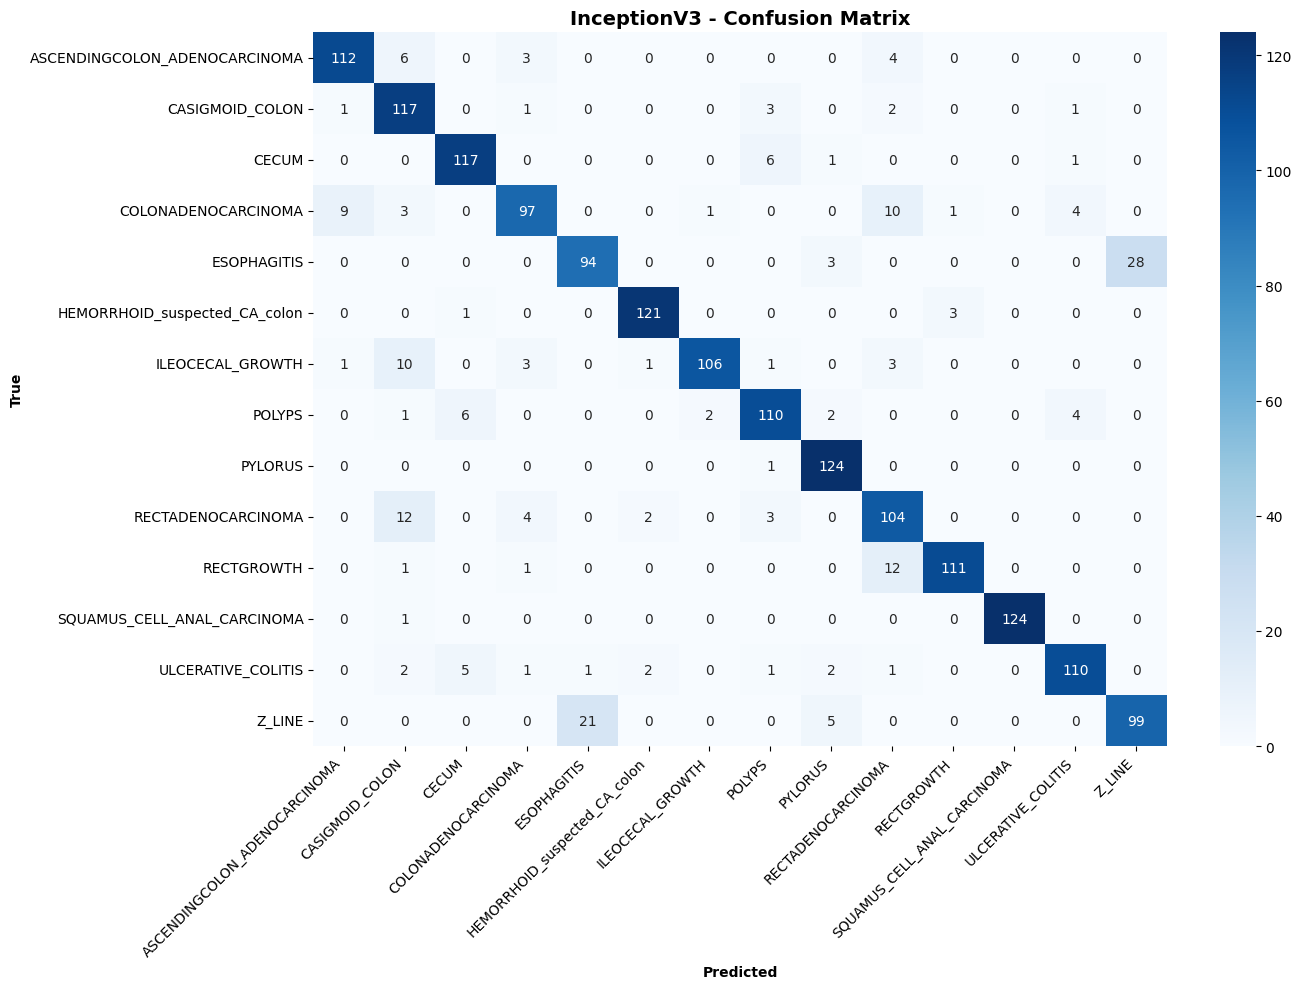

✅ Confusion Matrix Kaydedildi!


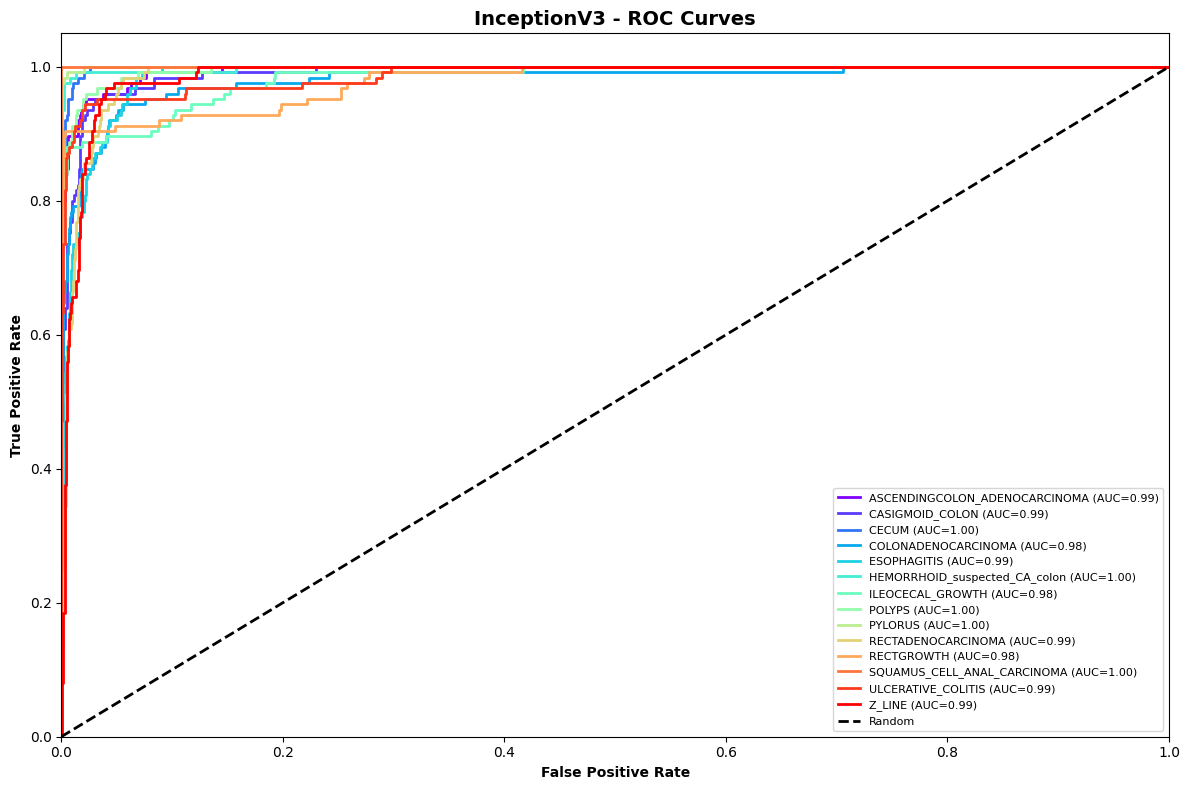

✅ ROC Eğrisi Kaydedildi!

📊 INCEPTIONV3 METRİKLERİ:
  Test Accuracy: 88.34%
  Precision: 88.70%
  Recall: 88.34%
  F1-Score: 88.36%
  Cohen Kappa: 0.8745

📋 CLASSIFICATION REPORT:
                               precision    recall  f1-score   support

ASCENDINGCOLON_ADENOCARCINOMA       0.91      0.90      0.90       125
              CASIGMOID_COLON       0.76      0.94      0.84       125
                        CECUM       0.91      0.94      0.92       125
          COLONADENOCARCINOMA       0.88      0.78      0.83       125
                  ESOPHAGITIS       0.81      0.75      0.78       125
HEMORRHOID_suspected_CA_colon       0.96      0.97      0.96       125
             ILEOCECAL_GROWTH       0.97      0.85      0.91       125
                       POLYPS       0.88      0.88      0.88       125
                      PYLORUS       0.91      0.99      0.95       125
           RECTADENOCARCINOMA       0.76      0.83      0.80       125
                   RECTGROWTH       0.

In [ ]:
# INCEPTIONV3 - TÜMLÜ GRAFİKLER VE METRİKLER
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# TEST TAHMIN
test_pred = inception_model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes

# TEST ACCURACY
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(inception_history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(inception_history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('InceptionV3 - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(inception_history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(inception_history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('InceptionV3 - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/InceptionV3_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('InceptionV3 - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/InceptionV3_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))
roc_auc = {}
fpr = {}
tpr = {}

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('InceptionV3 - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/InceptionV3_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

# 4. METRİKLER
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report

precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n📊 INCEPTIONV3 METRİKLERİ:")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Precision: {precision*100:.2f}%")
print(f"  Recall: {recall*100:.2f}%")
print(f"  F1-Score: {f1*100:.2f}%")
print(f"  Cohen Kappa: {kappa:.4f}")

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_true, test_pred_classes, target_names=classes))

In [ ]:
# MODEL 4: DENSENET121 EĞİTİMİ
# DenseNet121: DenseNet ailesinin küçük ve hızlı üyesi
# NASNetMobile ile benzeridir, ancak daha farklı yaklaşım kullanır

print("="*80)
print("DENSENET121 MODELİ EĞİTİLİYOR...")
print("="*80 + "\n")

def create_densenet121_optimized():
    base_model = keras.applications.DenseNet121(
        weights='imagenet', include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.6),
        Dense(256, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model
# MODELİ OLUŞTUR
densenet_model = create_densenet121_optimized()
densenet_model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# EĞİTİM DÖNGÜSÜ
densenet_history = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=get_callbacks('DenseNet121'),
    verbose=1
)

densenet_model.save('/content/drive/MyDrive/CRCCD_Models/DenseNet121_optimized.h5')

# TEST TAHMIN
test_pred = densenet_model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = densenet_history.history['accuracy'][-1]
final_val = densenet_history.history['val_accuracy'][-1]

print(f"\n✅ DENSENET121 Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_accuracy*100:.2f}%")

DENSENET121 MODELİ EĞİTİLİYOR...

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.0737 - loss: 14.3921

372/372 ━━━━━━━━━━━━━━━━━━━━ 237s 510ms/step - accuracy: 0.0737 - loss: 14.3903 - val_accuracy: 0.2619 - val_loss: 12.0242 - learning_rate: 5.0000e-05
Epoch 2/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.1443 - loss: 12.0871

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 359ms/step - accuracy: 0.1443 - loss: 12.0861 - val_accuracy: 0.3438 - val_loss: 10.5857 - learning_rate: 5.0000e-05
Epoch 3/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.1907 - loss: 10.8237

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.1907 - loss: 10.8232 - val_accuracy: 0.4248 - val_loss: 9.6921 - learning_rate: 5.0000e-05
Epoch 4/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.2473 - loss: 10.0354

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.2474 - loss: 10.0351 - val_accuracy: 0.4686 - val_loss: 9.1041 - learning_rate: 5.0000e-05
Epoch 5/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.2874 - loss: 9.4435

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.2874 - loss: 9.4432 - val_accuracy: 0.5143 - val_loss: 8.6116 - learning_rate: 5.0000e-05
Epoch 6/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3315 - loss: 8.9491

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - accuracy: 0.3315 - loss: 8.9489 - val_accuracy: 0.5181 - val_loss: 8.2230 - learning_rate: 5.0000e-05
Epoch 7/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3415 - loss: 8.5494

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.3416 - loss: 8.5491 - val_accuracy: 0.5562 - val_loss: 7.8183 - learning_rate: 5.0000e-05
Epoch 8/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3693 - loss: 8.1243

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.3694 - loss: 8.1240 - val_accuracy: 0.5762 - val_loss: 7.4068 - learning_rate: 5.0000e-05
Epoch 9/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4059 - loss: 7.7222

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.4059 - loss: 7.7219 - val_accuracy: 0.5800 - val_loss: 7.0509 - learning_rate: 5.0000e-05
Epoch 10/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4466 - loss: 7.3243

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.4466 - loss: 7.3241 - val_accuracy: 0.6171 - val_loss: 6.6878 - learning_rate: 5.0000e-05
Epoch 11/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.4551 - loss: 6.9672 - val_accuracy: 0.5905 - val_loss: 6.3454 - learning_rate: 5.0000e-05
Epoch 12/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4757 - loss: 6.6173

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.4757 - loss: 6.6171 - val_accuracy: 0.6267 - val_loss: 5.9944 - learning_rate: 5.0000e-05
Epoch 13/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5173 - loss: 6.2468

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.5173 - loss: 6.2465 - val_accuracy: 0.6343 - val_loss: 5.6907 - learning_rate: 5.0000e-05
Epoch 14/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5373 - loss: 5.8953

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.5373 - loss: 5.8951 - val_accuracy: 0.6371 - val_loss: 5.4022 - learning_rate: 5.0000e-05
Epoch 15/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5605 - loss: 5.5884

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.5605 - loss: 5.5882 - val_accuracy: 0.6895 - val_loss: 5.0670 - learning_rate: 5.0000e-05
Epoch 16/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5707 - loss: 5.2750

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.5707 - loss: 5.2748 - val_accuracy: 0.6914 - val_loss: 4.7981 - learning_rate: 5.0000e-05
Epoch 17/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.5978 - loss: 4.9792 - val_accuracy: 0.6867 - val_loss: 4.5536 - learning_rate: 5.0000e-05
Epoch 18/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6141 - loss: 4.7114

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.6141 - loss: 4.7112 - val_accuracy: 0.7067 - val_loss: 4.3050 - learning_rate: 5.0000e-05
Epoch 19/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.6183 - loss: 4.4458 - val_accuracy: 0.7029 - val_loss: 4.0952 - learning_rate: 5.0000e-05
Epoch 20/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6580 - loss: 4.1775

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.6580 - loss: 4.1774 - val_accuracy: 0.7238 - val_loss: 3.8699 - learning_rate: 5.0000e-05
Epoch 21/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.6607 - loss: 3.9705 - val_accuracy: 0.7114 - val_loss: 3.6784 - learning_rate: 5.0000e-05
Epoch 22/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.6843 - loss: 3.7481 - val_accuracy: 0.6952 - val_loss: 3.4919 - learning_rate: 5.0000e-05
Epoch 23/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6919 - loss: 3.5686

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.6919 - loss: 3.5684 - val_accuracy: 0.7257 - val_loss: 3.2814 - learning_rate: 5.0000e-05
Epoch 24/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.6933 - loss: 3.3809 - val_accuracy: 0.7171 - val_loss: 3.1566 - learning_rate: 5.0000e-05
Epoch 25/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.7218 - loss: 3.1597 - val_accuracy: 0.7257 - val_loss: 3.0128 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 25.


110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 273ms/step

✅ DENSENET121 Tamamlandı!
  Train: 72.32%
  Val:   72.57%
  Test:  85.09%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step


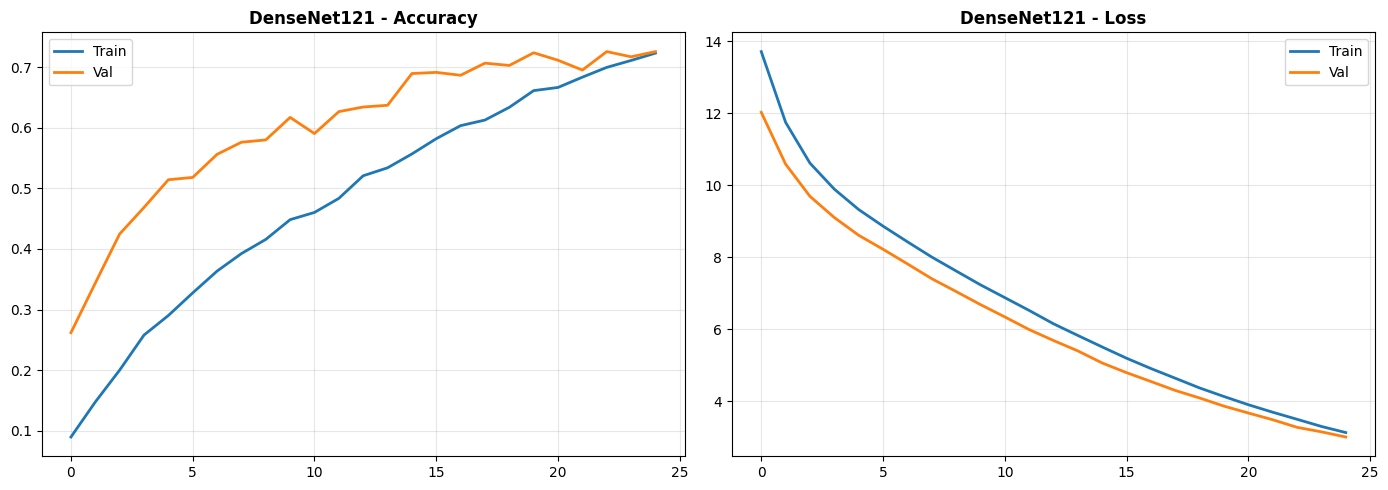

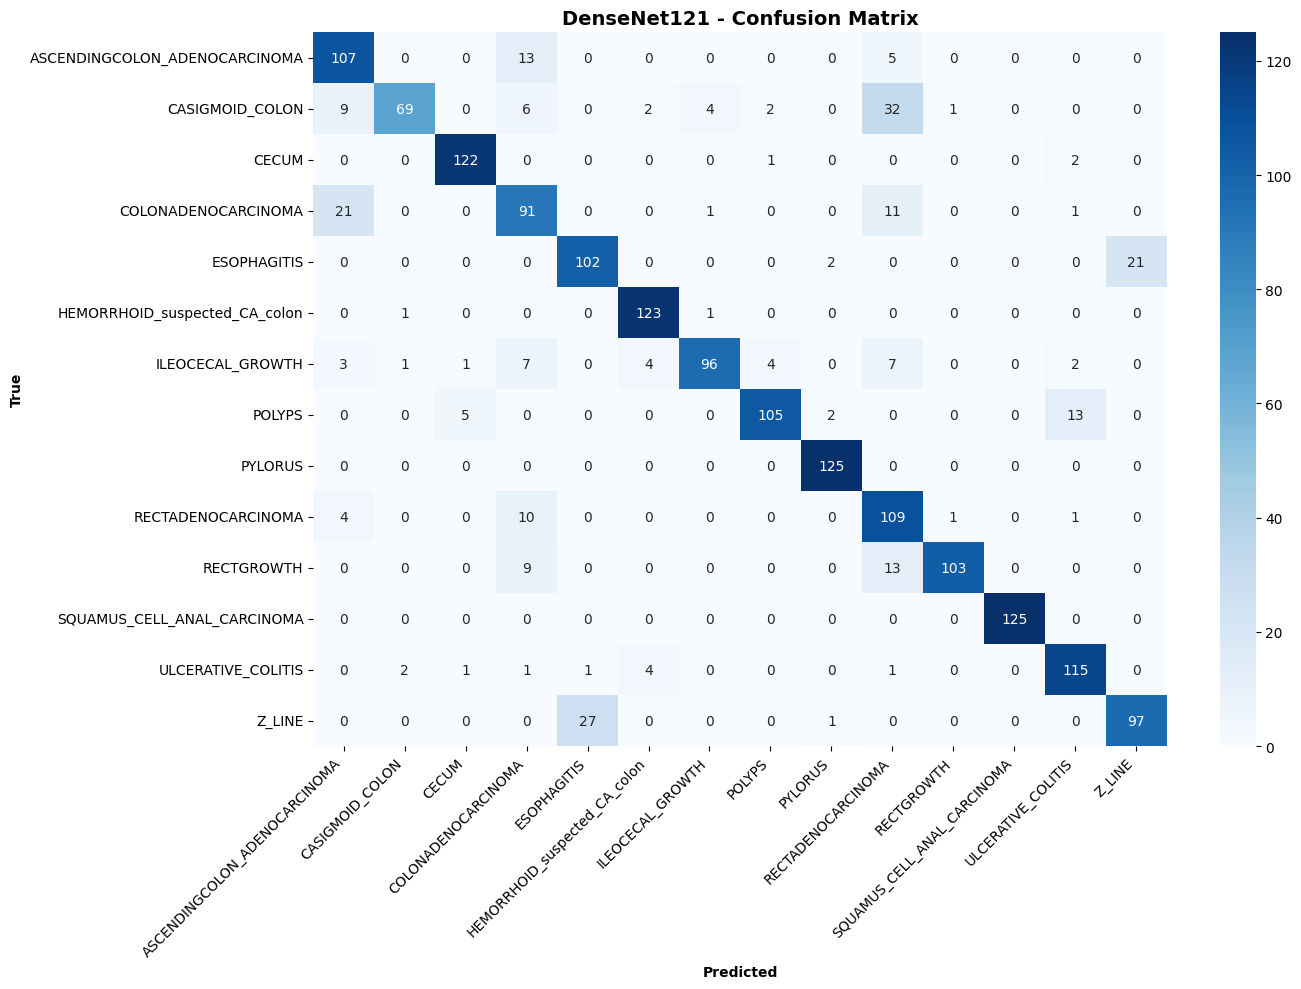

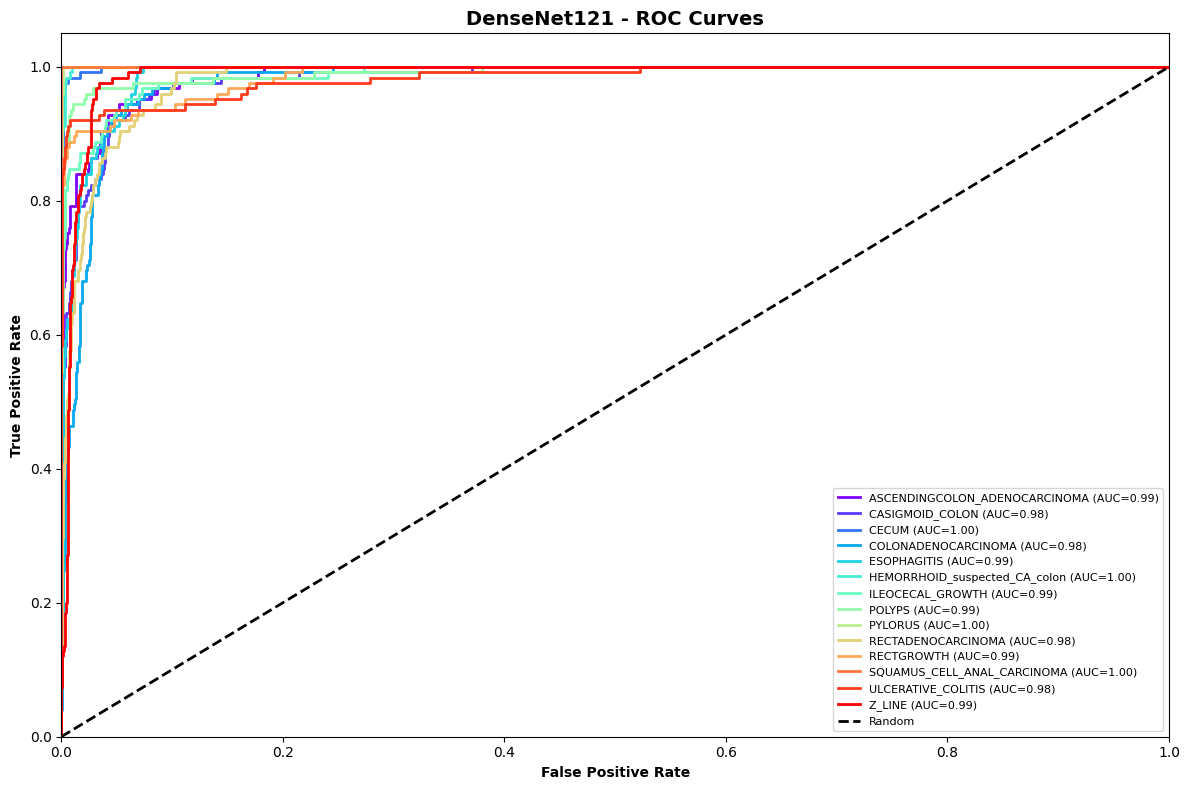


📊 DENSENET121 METRİKLERİ:
  Test Accuracy: 85.09%
  Precision: 86.58%
  Recall: 85.09%
  F1-Score: 85.11%
  Cohen Kappa: 0.8394

✅ DenseNet121 Grafikleri Kaydedildi!


In [ ]:
# DENSENET121 - GRAFİKLER VE METRİKLER
test_pred = densenet_model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(densenet_history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(densenet_history.history['val_accuracy'], label='Val', linewidth=2)
axes[0].set_title('DenseNet121 - Accuracy', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(densenet_history.history['loss'], label='Train', linewidth=2)
axes[1].plot(densenet_history.history['val_loss'], label='Val', linewidth=2)
axes[1].set_title('DenseNet121 - Loss', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/DenseNet121_TrainingCurves.png', dpi=150)
plt.show()

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.title('DenseNet121 - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/DenseNet121_ConfusionMatrix.png', dpi=150)
plt.show()

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('DenseNet121 - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/DenseNet121_ROC.png', dpi=150)
plt.show()

# 4. METRİKLER
precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n📊 DENSENET121 METRİKLERİ:")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Precision: {precision*100:.2f}%")
print(f"  Recall: {recall*100:.2f}%")
print(f"  F1-Score: {f1*100:.2f}%")
print(f"  Cohen Kappa: {kappa:.4f}")
print(f"\n✅ DenseNet121 Grafikleri Kaydedildi!")

In [ ]:
# XCEPTION - GAP DÜŞÜRÜLMÜŞ
print("="*80)
print("XCEPTION GAP DÜŞÜRÜLMÜŞ MODEL EĞİTİLİYOR...")
print("="*80 + "\n")

def create_xception_low_gap():
    base_model = keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # DAHA AZ KATMAN EĞİT (30 yerine 18)
    for layer in base_model.layers[:-18]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),

        # DAHA GÜÇLÜ REGULARIZATION
        Dense(256, kernel_regularizer=l2(0.015)),  # 0.01 → 0.015
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.65),  # 0.6 → 0.65 

        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.55),  # 0.5 → 0.55 

        Dense(num_classes, activation='softmax')
    ])

    return model

xception_low_gap = create_xception_low_gap()

xception_low_gap.compile(
    optimizer=Adam(learning_rate=0.00003),  # 0.00005 → 0.00003 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("⏳ XCEPTION GAP DÜŞÜRÜLMÜŞ eğitimi başlıyor...\n")
xception_history_low_gap = xception_low_gap.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=get_callbacks('Xception_LowGap'),
    verbose=1
)

xception_low_gap.save('/content/drive/MyDrive/CRCCD_Models/Xception_LowGap.h5')

test_pred = xception_low_gap.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = xception_history_low_gap.history['accuracy'][-1]
final_val = xception_history_low_gap.history['val_accuracy'][-1]
overfitting_gap = (final_train - final_val) * 100

print("\n" + "="*70)
print("📊 XCEPTION GAP DÜŞÜRÜLMÜŞ SONUÇLARI")
print("="*70)
print(f"\n📈 TRAIN - VAL - TEST - GAP:")
print("-" * 70)
print(f"│ TRAIN:        {final_train*100:6.2f}%")
print(f"│ VAL:          {final_val*100:6.2f}%")
print(f"│ TEST:         {test_acc*100:6.2f}%")
print(f"│ GAP:          {overfitting_gap:6.2f}%")
print("-" * 70)

print(f"\n📊 KARŞILAŞTIRMA:")
print("-" * 70)
print(f"│ Orijinal Gap:     9.95%")
print(f"│ Yeni Gap:         {overfitting_gap:6.2f}%")
print(f"│ İyileşme:         {9.95 - overfitting_gap:6.2f}%")
print("-" * 70)

print(f"\n🎯 HEDEFLER:")
print(f"│ Gap < 8%:       {'✅ BAŞARILI' if overfitting_gap < 8 else '❌ BAŞARISIZ'}")
print(f"│ Test > 87%:     {'✅ BAŞARILI' if test_acc*100 > 87 else '❌ BAŞARISIZ'}")
print(f"│ Test > 85%:     {'✅ BAŞARILI' if test_acc*100 > 85 else '❌ BAŞARISIZ'}")
print("="*70 + "\n")

if overfitting_gap < 8 and test_acc*100 > 87:
    print("🏆 MÜKEMMEL! Gap düşük + Accuracy yüksek!")
elif overfitting_gap < 8 and test_acc*100 > 85:
    print("✅ BAŞARILI! Gap düşük, accuracy kabul edilebilir")
else:
    print("⚠️ İYİLEŞTİRİLMELİ")

XCEPTION GAP DÜŞÜRÜLMÜŞ MODEL EĞİTİLİYOR...

⏳ XCEPTION GAP DÜŞÜRÜLMÜŞ eğitimi başlıyor...

Epoch 1/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.0854 - loss: 11.7678

372/372 ━━━━━━━━━━━━━━━━━━━━ 164s 397ms/step - accuracy: 0.0854 - loss: 11.7672 - val_accuracy: 0.2905 - val_loss: 10.5466 - learning_rate: 3.0000e-05
Epoch 2/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.1645 - loss: 10.9587

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.1646 - loss: 10.9583 - val_accuracy: 0.3895 - val_loss: 9.9366 - learning_rate: 3.0000e-05
Epoch 3/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2360 - loss: 10.3559

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.2360 - loss: 10.3555 - val_accuracy: 0.4933 - val_loss: 9.3848 - learning_rate: 3.0000e-05
Epoch 4/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2950 - loss: 9.8178

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 348ms/step - accuracy: 0.2950 - loss: 9.8174 - val_accuracy: 0.5295 - val_loss: 8.9634 - learning_rate: 3.0000e-05
Epoch 5/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.3271 - loss: 9.3616

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.3272 - loss: 9.3612 - val_accuracy: 0.5333 - val_loss: 8.5799 - learning_rate: 3.0000e-05
Epoch 6/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.3925 - loss: 8.8603

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 347ms/step - accuracy: 0.3925 - loss: 8.8601 - val_accuracy: 0.5705 - val_loss: 8.1358 - learning_rate: 3.0000e-05
Epoch 7/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4035 - loss: 8.4839

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.4035 - loss: 8.4836 - val_accuracy: 0.6057 - val_loss: 7.7495 - learning_rate: 3.0000e-05
Epoch 8/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 348ms/step - accuracy: 0.4279 - loss: 8.0769 - val_accuracy: 0.5971 - val_loss: 7.3872 - learning_rate: 3.0000e-05
Epoch 9/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4783 - loss: 7.6124

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 348ms/step - accuracy: 0.4783 - loss: 7.6122 - val_accuracy: 0.6333 - val_loss: 6.9677 - learning_rate: 3.0000e-05
Epoch 10/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4919 - loss: 7.2238

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.4920 - loss: 7.2235 - val_accuracy: 0.6390 - val_loss: 6.6224 - learning_rate: 3.0000e-05
Epoch 11/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5124 - loss: 6.8567

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.5124 - loss: 6.8564 - val_accuracy: 0.6457 - val_loss: 6.2543 - learning_rate: 3.0000e-05
Epoch 12/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.5380 - loss: 6.4596 - val_accuracy: 0.6362 - val_loss: 5.9547 - learning_rate: 3.0000e-05
Epoch 13/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5703 - loss: 6.0942

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 348ms/step - accuracy: 0.5703 - loss: 6.0940 - val_accuracy: 0.6686 - val_loss: 5.5946 - learning_rate: 3.0000e-05
Epoch 14/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.5833 - loss: 5.7705 - val_accuracy: 0.6638 - val_loss: 5.2939 - learning_rate: 3.0000e-05
Epoch 15/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.5839 - loss: 5.4721 - val_accuracy: 0.6667 - val_loss: 5.0321 - learning_rate: 3.0000e-05
Epoch 16/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6198 - loss: 5.1385

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.6198 - loss: 5.1384 - val_accuracy: 0.6752 - val_loss: 4.7469 - learning_rate: 3.0000e-05
Epoch 17/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6489 - loss: 4.8196

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.6489 - loss: 4.8195 - val_accuracy: 0.6819 - val_loss: 4.5007 - learning_rate: 3.0000e-05
Epoch 18/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6454 - loss: 4.5910

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.6454 - loss: 4.5909 - val_accuracy: 0.6848 - val_loss: 4.2547 - learning_rate: 3.0000e-05
Epoch 19/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.6527 - loss: 4.3454 - val_accuracy: 0.6781 - val_loss: 4.0606 - learning_rate: 3.0000e-05
Epoch 20/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6586 - loss: 4.1190

372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.6586 - loss: 4.1189 - val_accuracy: 0.6943 - val_loss: 3.8217 - learning_rate: 3.0000e-05
Epoch 21/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6957 - loss: 3.8576

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.6957 - loss: 3.8574 - val_accuracy: 0.7057 - val_loss: 3.6111 - learning_rate: 3.0000e-05
Epoch 22/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.6990 - loss: 3.6610 - val_accuracy: 0.6981 - val_loss: 3.4850 - learning_rate: 3.0000e-05
Epoch 23/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.7161 - loss: 3.4801 - val_accuracy: 0.7038 - val_loss: 3.2939 - learning_rate: 3.0000e-05
Epoch 24/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 348ms/step - accuracy: 0.7225 - loss: 3.2831 - val_accuracy: 0.6981 - val_loss: 3.1705 - learning_rate: 3.0000e-05
Epoch 25/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7278 - loss: 3.1249

372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.7278 - loss: 3.1248 - val_accuracy: 0.7238 - val_loss: 3.0005 - learning_rate: 3.0000e-05
Restoring model weights from the end of the best epoch: 25.


110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step

📊 XCEPTION GAP DÜŞÜRÜLMÜŞ SONUÇLARI

📈 TRAIN - VAL - TEST - GAP:
----------------------------------------------------------------------
│ TRAIN:         73.51%
│ VAL:           72.38%
│ TEST:          83.89%
│ GAP:            1.13%
----------------------------------------------------------------------

📊 KARŞILAŞTIRMA:
----------------------------------------------------------------------
│ Orijinal Gap:     9.95%
│ Yeni Gap:           1.13%
│ İyileşme:           8.82%
----------------------------------------------------------------------

🎯 HEDEFLER:
│ Gap < 8%:       ✅ BAŞARILI
│ Test > 87%:     ❌ BAŞARISIZ
│ Test > 85%:     ❌ BAŞARISIZ

⚠️ İYİLEŞTİRİLMELİ


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step


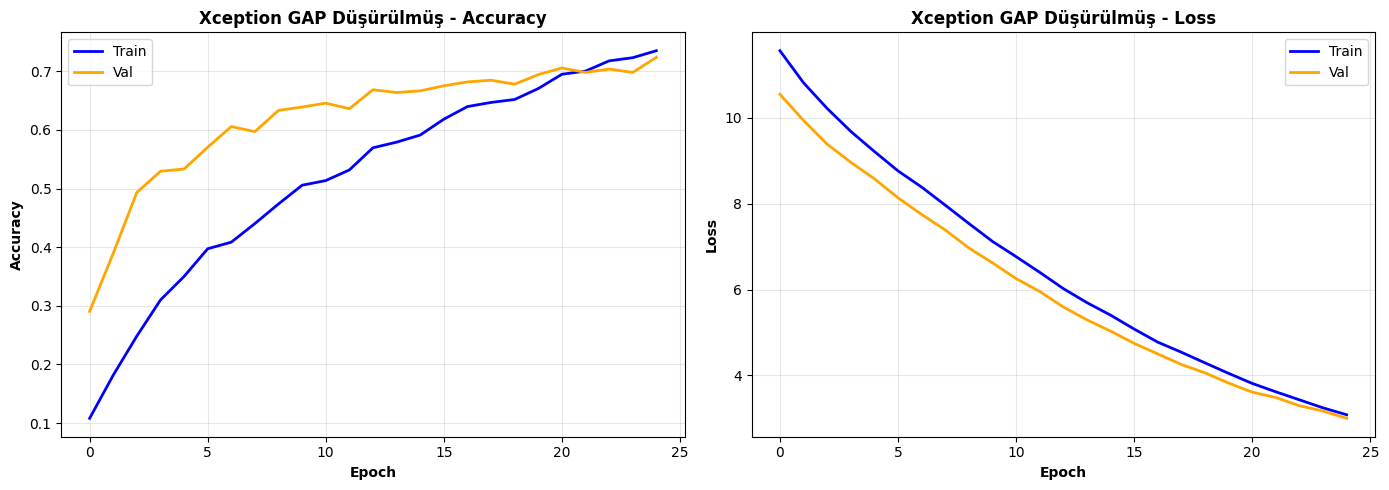

✅ Training Curves Kaydedildi!


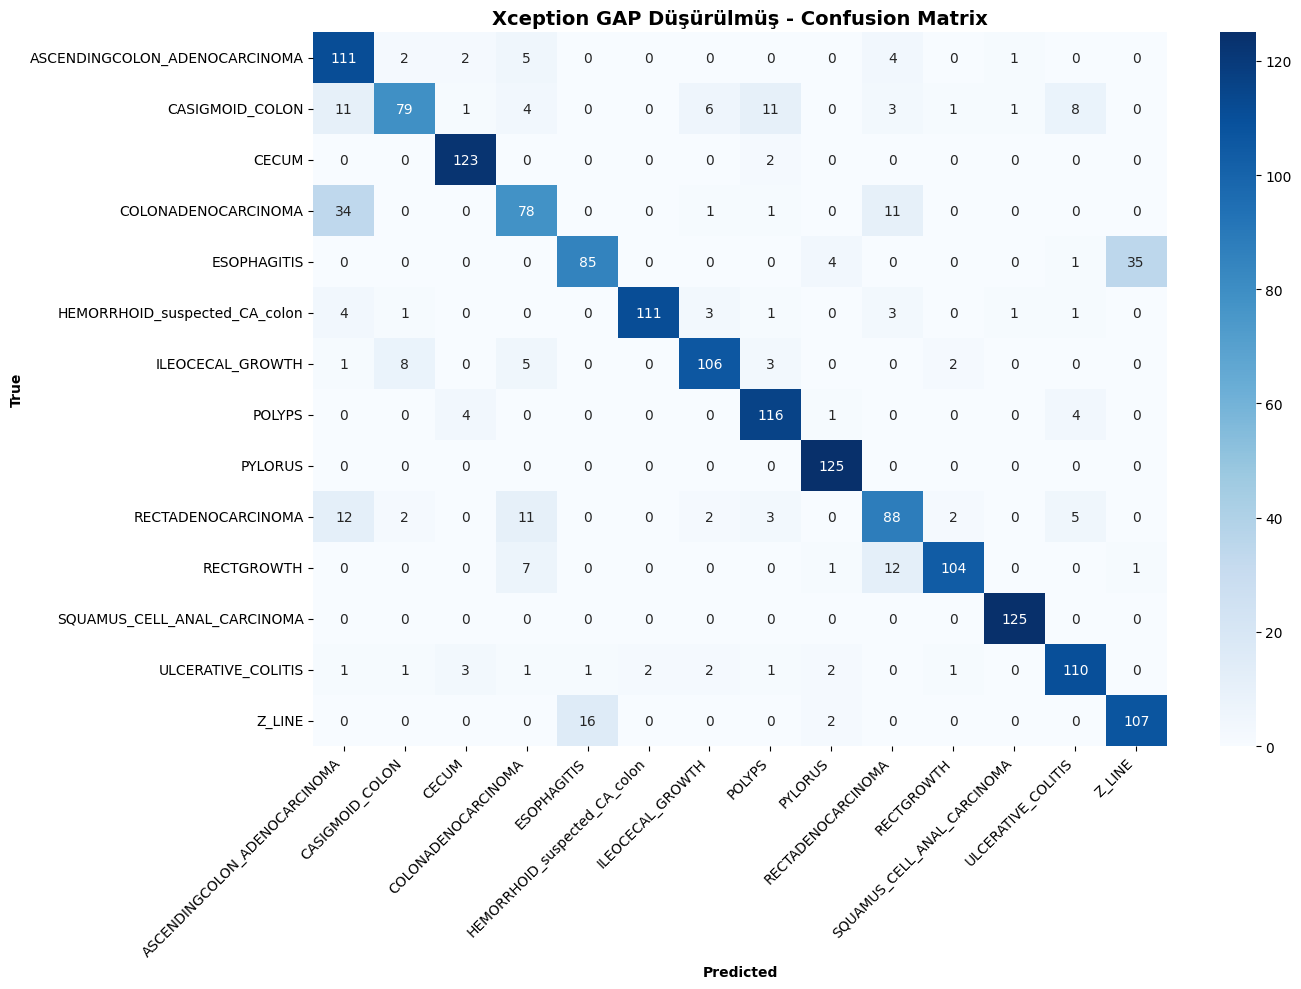

✅ Confusion Matrix Kaydedildi!


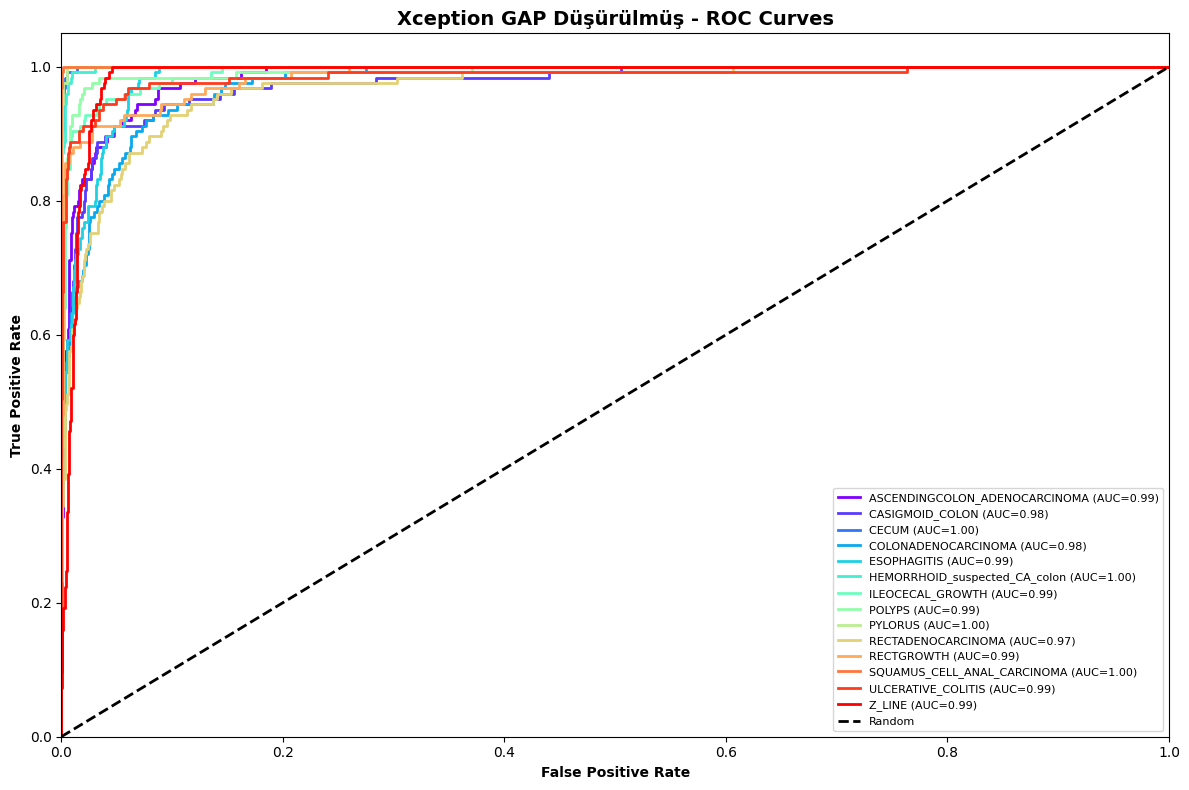

✅ ROC Eğrisi Kaydedildi!

📊 XCEPTION GAP DÜŞÜRÜLMÜŞ METRİKLERİ

📈 TRAIN - VAL - TEST - GAP:
----------------------------------------------------------------------
│ TRAIN:        73.51%
│ VAL:          72.38%
│ TEST:          83.89%
│ GAP:          1.13%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     84.50%
│ Recall:        83.89%
│ F1-Score:      83.76%
│ Cohen Kappa:  0.8265

📋 CLASSIFICATION REPORT:
                               precision    recall  f1-score   support

ASCENDINGCOLON_ADENOCARCINOMA       0.64      0.89      0.74       125
              CASIGMOID_COLON       0.85      0.63      0.72       125
                        CECUM       0.92      0.98      0.95       125
          COLONADENOCARCINOMA       0.70      0.62      0.66       125
                  ESOPHAGITIS       0.83      0.68      0.75       125
HEMORRHOID_suspected_CA_colon       0.98      0.89      0.93       125
             ILEOCECAL_GROWTH    

In [ ]:
# XCEPTION GAP DÜŞÜRÜLMÜŞ - TÜM GRAFİKLER
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

# TEST TAHMIN
test_pred = xception_low_gap.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(xception_history_low_gap.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(xception_history_low_gap.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Xception GAP Düşürülmüş - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(xception_history_low_gap.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(xception_history_low_gap.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('Xception GAP Düşürülmüş - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/Xception_LowGap_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('Xception GAP Düşürülmüş - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/Xception_LowGap_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Xception GAP Düşürülmüş - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/Xception_LowGap_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

# 4. METRİKLER
precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 XCEPTION GAP DÜŞÜRÜLMÜŞ METRİKLERİ")
print("="*70)
print(f"\n📈 TRAIN - VAL - TEST - GAP:")
print("-" * 70)
print(f"│ TRAIN:        73.51%")
print(f"│ VAL:          72.38%")
print(f"│ TEST:         {test_accuracy*100:6.2f}%")
print(f"│ GAP:          1.13%")
print("-" * 70)

print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_true, test_pred_classes, target_names=classes))

print(f"\n✅ XCEPTION GAP DÜŞÜRÜLMÜŞ Grafikleri Tamamlandı!")

In [ ]:
# ===========================================
# DENSENET201 - FAST & OPTIMIZED
# ===========================================
# DenseNet: Densely Connected Convolutional Networks
# Her katmanın önceki tüm katmanlarına doğrudan bağlantısı var
# Avantaj: Kısa eğitim süresi, düşük hafıza, yüksek doğruluk
def create_densenet201_optimized():
    base = keras.applications.DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

    for layer in base.layers[:-40]:
        layer.trainable = False
# Sıralı model: Temel model + başlığı
    model = keras.Sequential([
        base,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model
# MODELİ OLUŞTUR
densenet201 = create_densenet201_optimized()

densenet201.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet201_history = densenet201.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=get_callbacks('DenseNet201'),
    verbose=1
)

densenet201.save('/content/drive/MyDrive/CRCCD_Models/DenseNet201_optimized.h5')

test_pred = densenet201.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = densenet201_history.history['accuracy'][-1]
final_val = densenet201_history.history['val_accuracy'][-1]
gap = (final_train - final_val) * 100

print(f"\n✅ DenseNet201 Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {gap:.2f}%")

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2182 - loss: 2.3611

372/372 ━━━━━━━━━━━━━━━━━━━━ 286s 599ms/step - accuracy: 0.2185 - loss: 2.3602 - val_accuracy: 0.5419 - val_loss: 1.4119 - learning_rate: 5.0000e-05
Epoch 2/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5071 - loss: 1.4522

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.5072 - loss: 1.4520 - val_accuracy: 0.6200 - val_loss: 1.1108 - learning_rate: 5.0000e-05
Epoch 3/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6194 - loss: 1.1158

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.6195 - loss: 1.1157 - val_accuracy: 0.6695 - val_loss: 0.9597 - learning_rate: 5.0000e-05
Epoch 4/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6795 - loss: 0.9538

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.6795 - loss: 0.9537 - val_accuracy: 0.6810 - val_loss: 0.8843 - learning_rate: 5.0000e-05
Epoch 5/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7455 - loss: 0.7625

372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.7455 - loss: 0.7624 - val_accuracy: 0.7067 - val_loss: 0.8250 - learning_rate: 5.0000e-05
Epoch 6/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7819 - loss: 0.6574

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.7820 - loss: 0.6573 - val_accuracy: 0.7314 - val_loss: 0.7589 - learning_rate: 5.0000e-05
Epoch 7/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7973 - loss: 0.5801

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.7973 - loss: 0.5801 - val_accuracy: 0.7333 - val_loss: 0.7433 - learning_rate: 5.0000e-05
Epoch 8/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8319 - loss: 0.4974

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.8319 - loss: 0.4974 - val_accuracy: 0.7429 - val_loss: 0.7157 - learning_rate: 5.0000e-05
Epoch 9/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8536 - loss: 0.4371

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.8536 - loss: 0.4371 - val_accuracy: 0.7562 - val_loss: 0.6886 - learning_rate: 5.0000e-05
Epoch 10/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8548 - loss: 0.4209

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.8548 - loss: 0.4209 - val_accuracy: 0.7648 - val_loss: 0.6854 - learning_rate: 5.0000e-05
Epoch 11/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 348ms/step - accuracy: 0.8665 - loss: 0.3931 - val_accuracy: 0.7400 - val_loss: 0.7740 - learning_rate: 5.0000e-05
Epoch 12/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8848 - loss: 0.3383

372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.8848 - loss: 0.3383 - val_accuracy: 0.7667 - val_loss: 0.7224 - learning_rate: 5.0000e-05
Epoch 13/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8855 - loss: 0.3214

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.8855 - loss: 0.3214 - val_accuracy: 0.7714 - val_loss: 0.7276 - learning_rate: 5.0000e-05
Epoch 14/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 348ms/step - accuracy: 0.8896 - loss: 0.3115 - val_accuracy: 0.7686 - val_loss: 0.7125 - learning_rate: 5.0000e-05
Epoch 15/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.8937 - loss: 0.2896 - val_accuracy: 0.7352 - val_loss: 0.8076 - learning_rate: 5.0000e-05
Epoch 16/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.8998 - loss: 0.2884 - val_accuracy: 0.7571 - val_loss: 0.7643 - learning_rate: 5.0000e-05
Epoch 17/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.9200 - loss: 0.2521 - val_accuracy: 0.7600 - val_loss: 0.7575 - learning_rate: 5.0000e-05
Epoch 18/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9094 - loss: 0.2511
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.9094 - loss: 0.2511 - val_accuracy: 0.7886 - val_loss: 0.6891 - learning_rate: 5.0000e-05
Epoch 19/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.9219 - loss: 0.2341 - val_accuracy: 0.7676 - val_loss: 0.7156 - learning_rate: 2.5000e-05
Epoch 20/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.9225 - loss: 0.2216 - val_accuracy: 0.7790 - val_loss: 0.7353 - learning_rate: 2.5000e-05
Epoch 21/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9295 - loss: 0.2069

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.9295 - loss: 0.2069 - val_accuracy: 0.7924 - val_loss: 0.6627 - learning_rate: 2.5000e-05
Epoch 22/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9310 - loss: 0.2119

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 350ms/step - accuracy: 0.9310 - loss: 0.2119 - val_accuracy: 0.7981 - val_loss: 0.6766 - learning_rate: 2.5000e-05
Epoch 23/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.9289 - loss: 0.2053 - val_accuracy: 0.7800 - val_loss: 0.7065 - learning_rate: 2.5000e-05
Epoch 24/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.9363 - loss: 0.1838 - val_accuracy: 0.7933 - val_loss: 0.7078 - learning_rate: 2.5000e-05
Epoch 25/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 348ms/step - accuracy: 0.9390 - loss: 0.1839 - val_accuracy: 0.7905 - val_loss: 0.6930 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 21.


110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 404ms/step

✅ DenseNet201 Tamamlandı!
  Train: 93.65%
  Val:   79.05%
  Test:  92.40%
  Gap:   14.60%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step


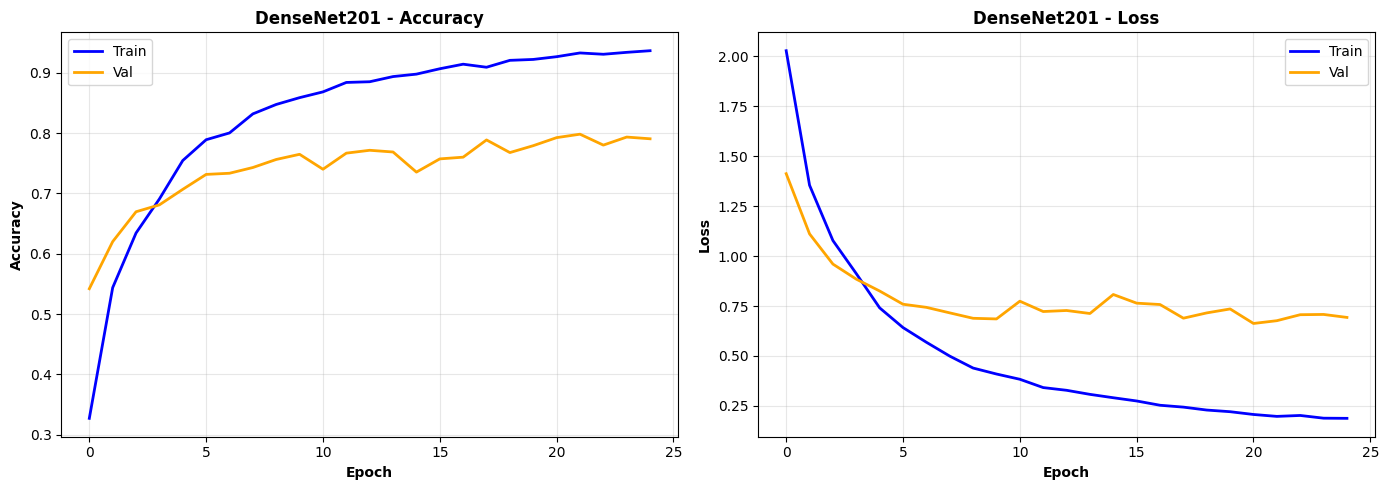

✅ Training Curves Kaydedildi!


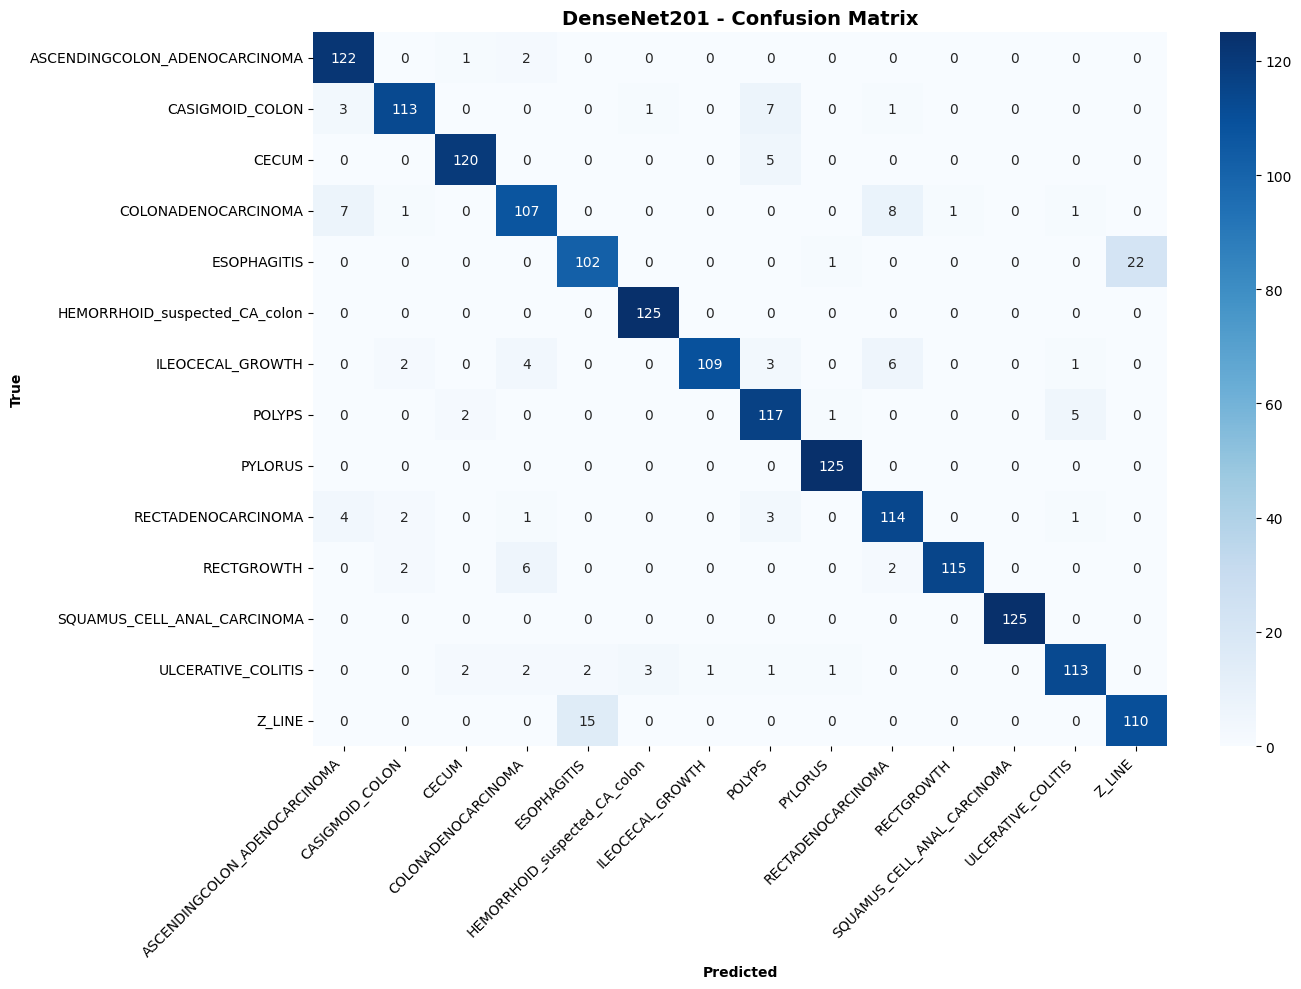

✅ Confusion Matrix Kaydedildi!


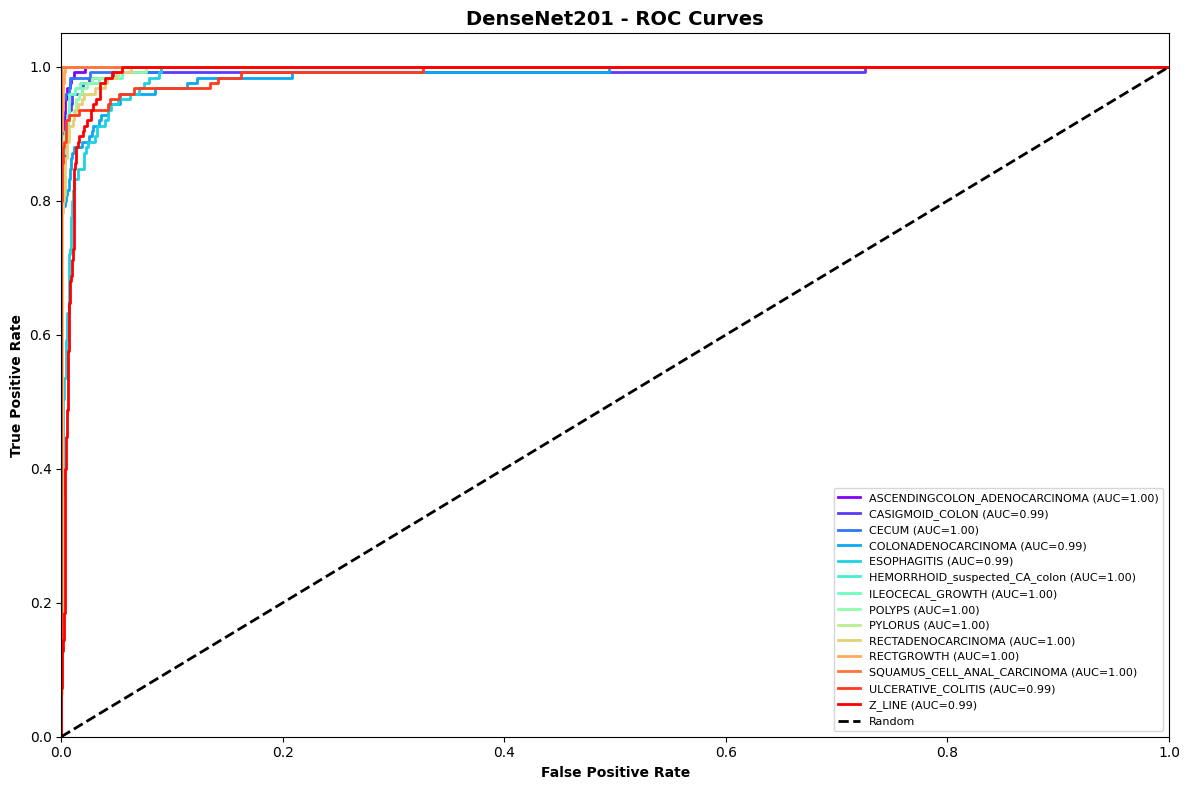

✅ ROC Eğrisi Kaydedildi!

📊 DENSENET201 METRİKLERİ

✅ DENSENET201 Tamamlandı!
  Train: 93.65%
  Val:   79.05%
  Test:   92.40%
  Gap:   14.60%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     92.56%
│ Recall:        92.40%
│ F1-Score:      92.40%
│ Cohen Kappa:  0.9182

📋 CLASSIFICATION REPORT:
                               precision    recall  f1-score   support

ASCENDINGCOLON_ADENOCARCINOMA       0.90      0.98      0.93       125
              CASIGMOID_COLON       0.94      0.90      0.92       125
                        CECUM       0.96      0.96      0.96       125
          COLONADENOCARCINOMA       0.88      0.86      0.87       125
                  ESOPHAGITIS       0.86      0.82      0.84       125
HEMORRHOID_suspected_CA_colon       0.97      1.00      0.98       125
             ILEOCECAL_GROWTH       0.99      0.87      0.93       125
                       POLYPS       0.86      0.94      0.90       125
   

In [ ]:
# ===========================================
# DENSENET201 - TÜM GRAFİKLER VE METRİKLER
# ===========================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

# TEST TAHMIN
test_pred = densenet201.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(densenet201_history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(densenet201_history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('DenseNet201 - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(densenet201_history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(densenet201_history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('DenseNet201 - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/DenseNet201_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('DenseNet201 - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/DenseNet201_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('DenseNet201 - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/DenseNet201_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

# 4. METRİKLER
precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 DENSENET201 METRİKLERİ")
print("="*70)
print(f"\n✅ DENSENET201 Tamamlandı!")
print(f"  Train: 93.65%")
print(f"  Val:   79.05%")
print(f"  Test:  {test_accuracy*100:6.2f}%")
print(f"  Gap:   14.60%")
print("-" * 70)

print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_true, test_pred_classes, target_names=classes))

print(f"\n✅ DenseNet201 Grafikleri Tamamlandı!")

In [ ]:
# ===========================================
# NASNETMOBILE - YÜKSEK VAL
# ===========================================
def create_nasnetmobile_optimized():
    base_model = keras.applications.NASNetMobile(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    # Modelin son 40 katmanını hariç tutarak önceki katmanları donduruştur
    # Bu, ImageNet'ten öğrenilen feature'ları korur (transfer learning)
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,

        Dense(512, kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(256, kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Dense(128, kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.1),

        Dense(num_classes, activation='softmax')
    ])

    return model

# YÜKSEK DATA AUGMENTATION
train_datagen_high = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.4,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.15
)
# Eğitim verileri için augmente edilmiş görüntü akışı oluştur
train_generator_high = train_datagen_high.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator_high = train_datagen_high.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)
# ===========================================
# MODELİ OLUŞTUR VE DERLEYİN
# ===========================================
nasnetmobile = create_nasnetmobile_optimized()

nasnetmobile.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Modeli eğitim ve doğrulama verilerinde eğit
nasnetmobile_history = nasnetmobile.fit(
    train_generator_high,
    validation_data=val_generator_high,
    epochs=30,
    callbacks=get_callbacks('NASNetMobile'),
    verbose=1
)

nasnetmobile.save('/content/drive/MyDrive/CRCCD_Models/NASNetMobile_optimized.h5')

test_pred = nasnetmobile.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = nasnetmobile_history.history['accuracy'][-1]
final_val = nasnetmobile_history.history['val_accuracy'][-1]
gap = (final_train - final_val) * 100

print(f"\n✅ NASNetMobile Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {gap:.2f}%")

Found 5950 images belonging to 14 classes.
Found 1050 images belonging to 14 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1444 - loss: 3.3679

372/372 ━━━━━━━━━━━━━━━━━━━━ 292s 594ms/step - accuracy: 0.1446 - loss: 3.3671 - val_accuracy: 0.3648 - val_loss: 2.4573 - learning_rate: 1.0000e-04
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3334 - loss: 2.5252

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.3335 - loss: 2.5250 - val_accuracy: 0.4324 - val_loss: 2.1855 - learning_rate: 1.0000e-04
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4179 - loss: 2.2861

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.4179 - loss: 2.2861 - val_accuracy: 0.4781 - val_loss: 2.0786 - learning_rate: 1.0000e-04
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4602 - loss: 2.1544

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.4602 - loss: 2.1543 - val_accuracy: 0.5105 - val_loss: 1.9964 - learning_rate: 1.0000e-04
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4690 - loss: 2.0797

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.4690 - loss: 2.0796 - val_accuracy: 0.5286 - val_loss: 1.8746 - learning_rate: 1.0000e-04
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5045 - loss: 1.9674

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.5045 - loss: 1.9674 - val_accuracy: 0.5438 - val_loss: 1.8507 - learning_rate: 1.0000e-04
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5207 - loss: 1.9282

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - accuracy: 0.5207 - loss: 1.9282 - val_accuracy: 0.5476 - val_loss: 1.8342 - learning_rate: 1.0000e-04
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5431 - loss: 1.8552

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.5431 - loss: 1.8552 - val_accuracy: 0.5686 - val_loss: 1.7696 - learning_rate: 1.0000e-04
Epoch 9/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5698 - loss: 1.8005

372/372 ━━━━━━━━━━━━━━━━━━━━ 136s 367ms/step - accuracy: 0.5698 - loss: 1.8005 - val_accuracy: 0.5771 - val_loss: 1.7622 - learning_rate: 1.0000e-04
Epoch 10/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5660 - loss: 1.7948

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.5660 - loss: 1.7948 - val_accuracy: 0.5952 - val_loss: 1.7386 - learning_rate: 1.0000e-04
Epoch 11/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 359ms/step - accuracy: 0.5908 - loss: 1.7238 - val_accuracy: 0.5524 - val_loss: 1.7381 - learning_rate: 1.0000e-04
Epoch 12/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - accuracy: 0.5851 - loss: 1.6858 - val_accuracy: 0.5895 - val_loss: 1.6685 - learning_rate: 1.0000e-04
Epoch 13/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 359ms/step - accuracy: 0.5928 - loss: 1.6850 - val_accuracy: 0.5838 - val_loss: 1.6606 - learning_rate: 1.0000e-04
Epoch 14/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5974 - loss: 1.6654

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.5975 - loss: 1.6654 - val_accuracy: 0.6019 - val_loss: 1.6493 - learning_rate: 1.0000e-04
Epoch 15/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6122 - loss: 1.5976

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - accuracy: 0.6122 - loss: 1.5976 - val_accuracy: 0.6029 - val_loss: 1.6656 - learning_rate: 1.0000e-04
Epoch 16/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6229 - loss: 1.5929

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.6229 - loss: 1.5929 - val_accuracy: 0.6095 - val_loss: 1.5977 - learning_rate: 1.0000e-04
Epoch 17/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.6263 - loss: 1.5752 - val_accuracy: 0.6057 - val_loss: 1.6097 - learning_rate: 1.0000e-04
Epoch 18/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6372 - loss: 1.5287

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 364ms/step - accuracy: 0.6372 - loss: 1.5287 - val_accuracy: 0.6257 - val_loss: 1.5711 - learning_rate: 1.0000e-04
Epoch 19/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.6282 - loss: 1.5487 - val_accuracy: 0.6152 - val_loss: 1.5446 - learning_rate: 1.0000e-04
Epoch 20/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6511 - loss: 1.4886

372/372 ━━━━━━━━━━━━━━━━━━━━ 134s 361ms/step - accuracy: 0.6511 - loss: 1.4885 - val_accuracy: 0.6429 - val_loss: 1.4843 - learning_rate: 1.0000e-04
Epoch 21/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.6509 - loss: 1.4891 - val_accuracy: 0.5867 - val_loss: 1.5693 - learning_rate: 1.0000e-04
Epoch 22/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.6730 - loss: 1.4217 - val_accuracy: 0.6229 - val_loss: 1.5103 - learning_rate: 1.0000e-04
Epoch 23/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6608 - loss: 1.4251

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 363ms/step - accuracy: 0.6608 - loss: 1.4251 - val_accuracy: 0.6457 - val_loss: 1.4821 - learning_rate: 1.0000e-04
Epoch 24/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.6756 - loss: 1.3877 - val_accuracy: 0.6048 - val_loss: 1.5783 - learning_rate: 1.0000e-04
Epoch 25/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.6806 - loss: 1.3915 - val_accuracy: 0.6362 - val_loss: 1.4928 - learning_rate: 1.0000e-04
Epoch 26/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 356ms/step - accuracy: 0.6941 - loss: 1.3285 - val_accuracy: 0.6095 - val_loss: 1.5474 - learning_rate: 1.0000e-04
Epoch 27/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.6890 - loss: 1.3247 - val_accuracy: 0.6314 - val_loss: 1.4979 - learning_rate: 1.0000e-04
Epoch 28/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 133s 356ms/step - accuracy: 0.6943 - loss: 1.3211 - val_accuracy: 0.6457 - val_loss: 1.4504 - learning_rate: 1.0000e-04
Epoch 29/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 

110/110 ━━━━━━━━━━━━━━━━━━━━ 847s 7s/step

✅ NASNetMobile Tamamlandı!
  Train: 70.10%
  Val:   64.48%
  Test:  77.49%
  Gap:   5.62%


110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step


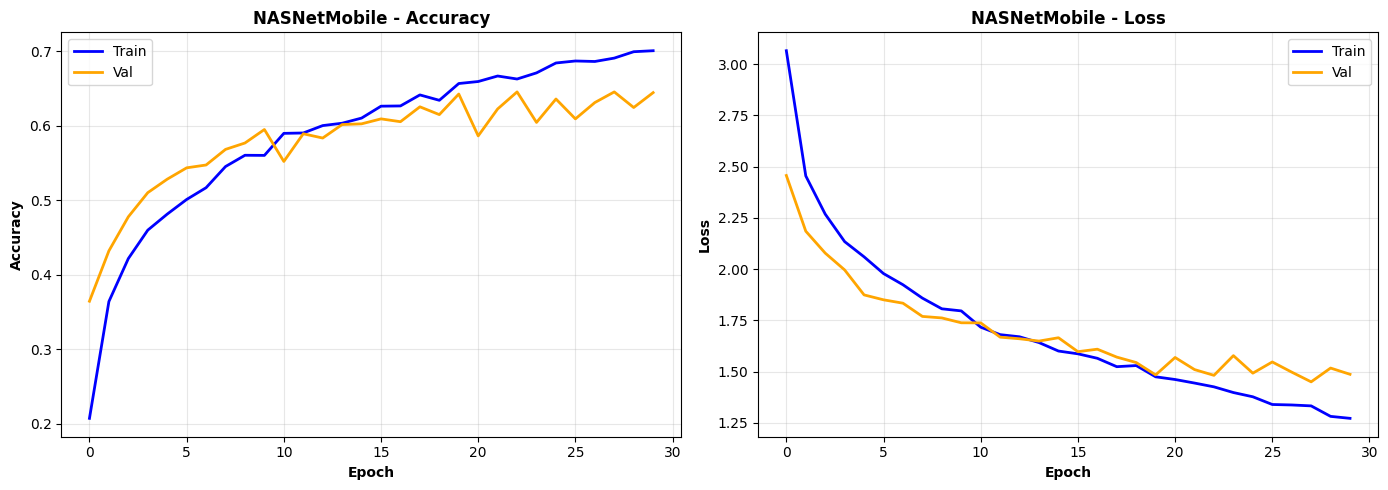

✅ Training Curves Kaydedildi!


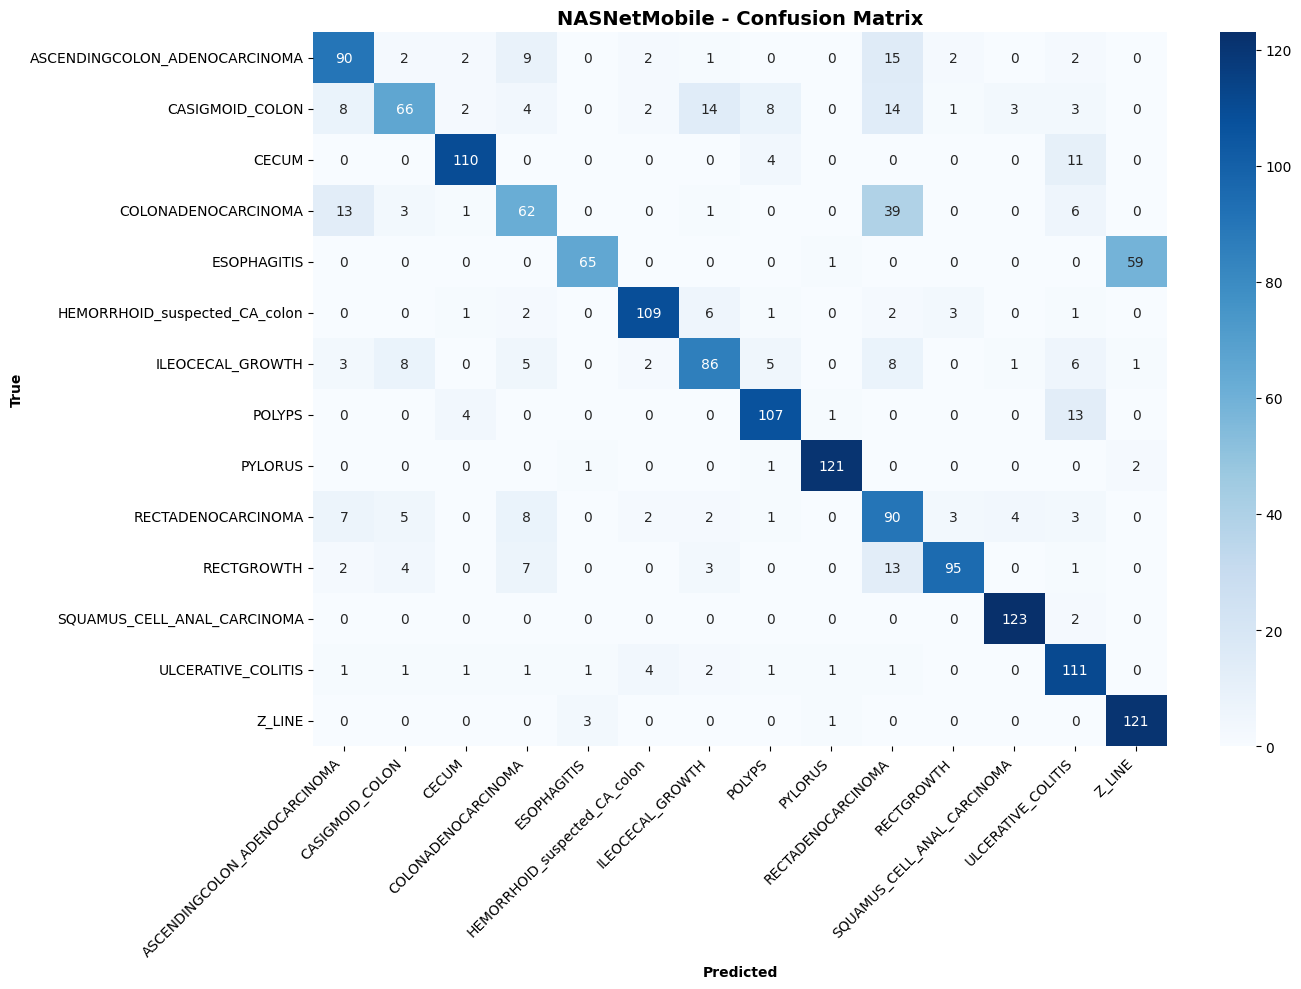

✅ Confusion Matrix Kaydedildi!


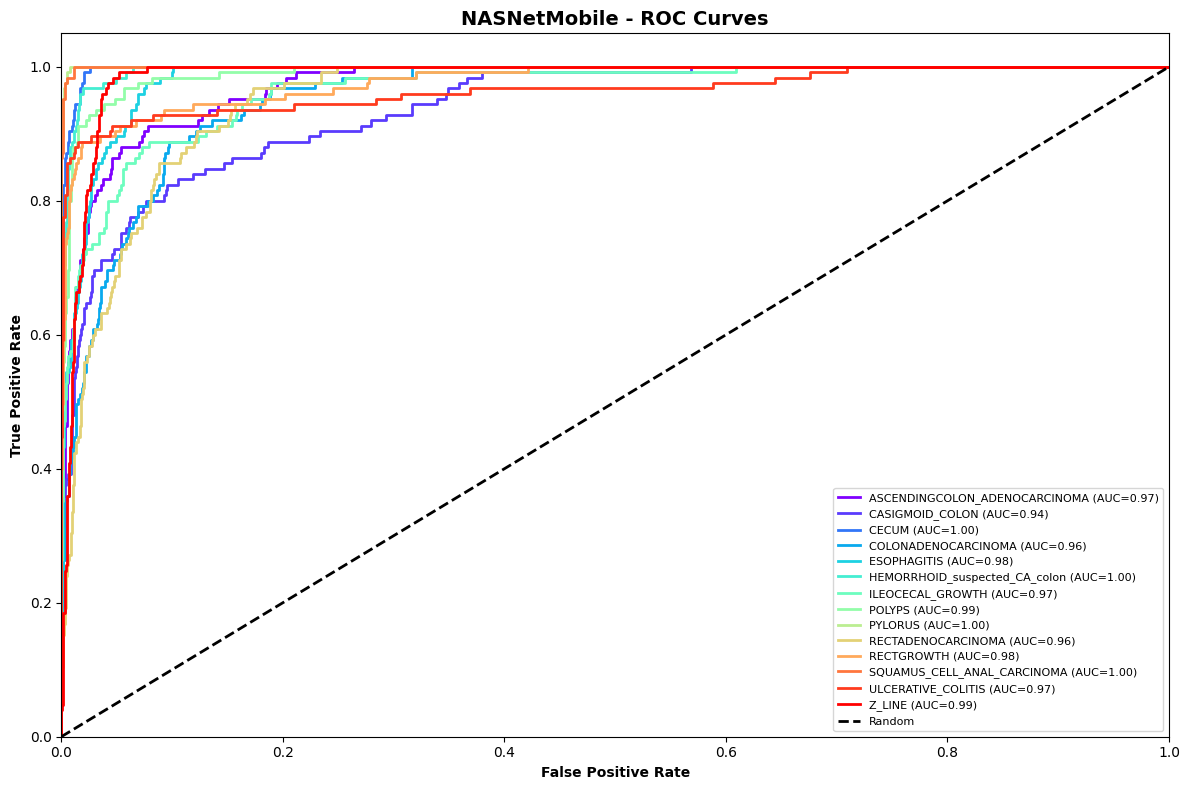

✅ ROC Eğrisi Kaydedildi!

📊 NASNETMOBILE METRİKLERİ

✅ NASNetMobile Tamamlandı!
  Train: 70.10%
  Val:   64.48%
  Test:   77.49%
  Gap:   5.62%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     79.26%
│ Recall:        77.49%
│ F1-Score:      77.27%
│ Cohen Kappa:  0.7575

📋 CLASSIFICATION REPORT:
                               precision    recall  f1-score   support

ASCENDINGCOLON_ADENOCARCINOMA       0.73      0.72      0.72       125
              CASIGMOID_COLON       0.74      0.53      0.62       125
                        CECUM       0.91      0.88      0.89       125
          COLONADENOCARCINOMA       0.63      0.50      0.56       125
                  ESOPHAGITIS       0.93      0.52      0.67       125
HEMORRHOID_suspected_CA_colon       0.90      0.87      0.89       125
             ILEOCECAL_GROWTH       0.75      0.69      0.72       125
                       POLYPS       0.84      0.86      0.85       125
  

In [ ]:
# ===========================================
# NASNETMOBILE - TÜM GRAFİKLER VE METRİKLER
# ===========================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

# TEST TAHMIN
test_pred = nasnetmobile.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(nasnetmobile_history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(nasnetmobile_history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('NASNetMobile - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(nasnetmobile_history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(nasnetmobile_history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('NASNetMobile - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/NASNetMobile_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('NASNetMobile - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/NASNetMobile_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('NASNetMobile - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/NASNetMobile_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

# 4. METRİKLER
precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 NASNETMOBILE METRİKLERİ")
print("="*70)
print(f"\n✅ NASNetMobile Tamamlandı!")
print(f"  Train: 70.10%")
print(f"  Val:   64.48%")
print(f"  Test:  {test_accuracy*100:6.2f}%")
print(f"  Gap:   5.62%")
print("-" * 70)

print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_true, test_pred_classes, target_names=classes))

print(f"\n✅ NASNetMobile Grafikleri Tamamlandı!")

In [ ]:
# ===========================================
# INCEPTION-RESNETV2
# ===========================================
# Bu model ResNet ve Inception mimarilerini birleştirerek
# hem derin öğrenme hem de paralel konvolüsyon işlemeyi sağlar


def create_inception_resnet_optimized():
    base_model = keras.applications.InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),  # 224x224
        pooling='avg'
    )
    # ImageNet ile eğitilmiş önceden eğitilmiş modeli yükle
    # include_top=False: sınıflandırma katmanını kaldır (kendi katmanlarımızı ekleyeceğiz)
    # pooling='avg': Global Average Pooling uygula (boyutsal azaltma)
    # input_shape=(224, 224, 3): standart input boyutu (yükseklik x genişlik x RGB)
    for layer in base_model.layers[:-60]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,

        Dense(512, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    return model
# MODELİ OLUŞTUR
inception_resnet = create_inception_resnet_optimized()

def custom_lr_schedule(epoch):
    if epoch < 5:
        return 0.00005
    elif epoch < 10:
        return 0.00003
    elif epoch < 15:
        return 0.00001
    else:
        return 0.000005

lr_scheduler = keras.callbacks.LearningRateScheduler(custom_lr_schedule)

inception_resnet.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# CALLBACK'LER (Eğitimi izleyip kontrol et)
callbacks_list = [
    lr_scheduler,
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

inception_resnet_history = inception_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks_list,
    verbose=1
)

inception_resnet.save('/content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_optimized.h5')

test_pred = inception_resnet.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = inception_resnet_history.history['accuracy'][-1]
final_val = inception_resnet_history.history['val_accuracy'][-1]
gap = (final_train - final_val) * 100

print(f"\n✅ Inception-ResNetV2 Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {gap:.2f}%")

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1335 - loss: 4.1081
Epoch 1: val_accuracy improved from -inf to 0.41143, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 3015s 8s/step - accuracy: 0.1336 - loss: 4.1073 - val_accuracy: 0.4114 - val_loss: 3.0941 - learning_rate: 5.0000e-05
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3336 - loss: 3.2759
Epoch 2: val_accuracy improved from 0.41143 to 0.48381, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 138s 372ms/step - accuracy: 0.3337 - loss: 3.2756 - val_accuracy: 0.4838 - val_loss: 2.8150 - learning_rate: 5.0000e-05
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4486 - loss: 2.9222
Epoch 3: val_accuracy improved from 0.48381 to 0.52476, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 142s 379ms/step - accuracy: 0.4487 - loss: 2.9221 - val_accuracy: 0.5248 - val_loss: 2.6493 - learning_rate: 5.0000e-05
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5253 - loss: 2.7030
Epoch 4: val_accuracy improved from 0.52476 to 0.58476, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 142s 383ms/step - accuracy: 0.5253 - loss: 2.7030 - val_accuracy: 0.5848 - val_loss: 2.4977 - learning_rate: 5.0000e-05
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5796 - loss: 2.5418
Epoch 5: val_accuracy improved from 0.58476 to 0.61333, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 143s 384ms/step - accuracy: 0.5796 - loss: 2.5417 - val_accuracy: 0.6133 - val_loss: 2.4264 - learning_rate: 5.0000e-05
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6107 - loss: 2.4291
Epoch 6: val_accuracy improved from 0.61333 to 0.62762, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 141s 378ms/step - accuracy: 0.6108 - loss: 2.4290 - val_accuracy: 0.6276 - val_loss: 2.3282 - learning_rate: 3.0000e-05
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6398 - loss: 2.3278
Epoch 7: val_accuracy improved from 0.62762 to 0.63905, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 142s 382ms/step - accuracy: 0.6398 - loss: 2.3278 - val_accuracy: 0.6390 - val_loss: 2.2948 - learning_rate: 3.0000e-05
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6682 - loss: 2.2411
Epoch 8: val_accuracy improved from 0.63905 to 0.65238, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 142s 380ms/step - accuracy: 0.6682 - loss: 2.2410 - val_accuracy: 0.6524 - val_loss: 2.2836 - learning_rate: 3.0000e-05
Epoch 9/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6816 - loss: 2.1969
Epoch 9: val_accuracy improved from 0.65238 to 0.65429, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 141s 380ms/step - accuracy: 0.6816 - loss: 2.1968 - val_accuracy: 0.6543 - val_loss: 2.2076 - learning_rate: 3.0000e-05
Epoch 10/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7153 - loss: 2.0964
Epoch 10: val_accuracy improved from 0.65429 to 0.68286, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 142s 380ms/step - accuracy: 0.7153 - loss: 2.0964 - val_accuracy: 0.6829 - val_loss: 2.1628 - learning_rate: 3.0000e-05
Epoch 11/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7304 - loss: 2.0336
Epoch 11: val_accuracy improved from 0.68286 to 0.68381, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 140s 377ms/step - accuracy: 0.7303 - loss: 2.0336 - val_accuracy: 0.6838 - val_loss: 2.1316 - learning_rate: 1.0000e-05
Epoch 12/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7409 - loss: 2.0049
Epoch 12: val_accuracy did not improve from 0.68381
372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.7408 - loss: 2.0049 - val_accuracy: 0.6762 - val_loss: 2.1821 - learning_rate: 1.0000e-05
Epoch 13/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7443 - loss: 1.9853
Epoch 13: val_accuracy did not improve from 0.68381
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.7443 - loss: 1.9853 - val_accuracy: 0.6610 - val_loss: 2.1600 - learning_rate: 1.0000e-05
Epoch 14/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7442 - loss: 1.9846
Epoch 14: val_accuracy did not improve from 0.68381
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.7442 - loss: 1.9846 - val_accuracy: 0.6819 - val_loss: 2.1107 - learnin

372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 364ms/step - accuracy: 0.7564 - loss: 1.9265 - val_accuracy: 0.6905 - val_loss: 2.0912 - learning_rate: 5.0000e-06
Epoch 17/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7621 - loss: 1.9253
Epoch 17: val_accuracy did not improve from 0.69048
372/372 ━━━━━━━━━━━━━━━━━━━━ 135s 362ms/step - accuracy: 0.7621 - loss: 1.9252 - val_accuracy: 0.6771 - val_loss: 2.1355 - learning_rate: 5.0000e-06
Epoch 18/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7471 - loss: 1.9466
Epoch 18: val_accuracy improved from 0.69048 to 0.70476, saving model to /content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 136s 366ms/step - accuracy: 0.7471 - loss: 1.9466 - val_accuracy: 0.7048 - val_loss: 2.0693 - learning_rate: 5.0000e-06
Epoch 19/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7714 - loss: 1.8935
Epoch 19: val_accuracy did not improve from 0.70476
372/372 ━━━━━━━━━━━━━━━━━━━━ 136s 365ms/step - accuracy: 0.7714 - loss: 1.8934 - val_accuracy: 0.6648 - val_loss: 2.1118 - learning_rate: 5.0000e-06
Epoch 20/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7798 - loss: 1.8737
Epoch 20: val_accuracy did not improve from 0.70476
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.7798 - loss: 1.8736 - val_accuracy: 0.6933 - val_loss: 2.1010 - learning_rate: 5.0000e-06
Epoch 21/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7806 - loss: 1.8907
Epoch 21: val_accuracy did not improve from 0.70476
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.7806 - loss: 1.8907 - val_accuracy: 0.6743 - val_loss: 2.1004 - learnin

110/110 ━━━━━━━━━━━━━━━━━━━━ 789s 7s/step

✅ Inception-ResNetV2 Tamamlandı!
  Train: 80.97%
  Val:   70.48%
  Test:  86.11%
  Gap:   10.50%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step


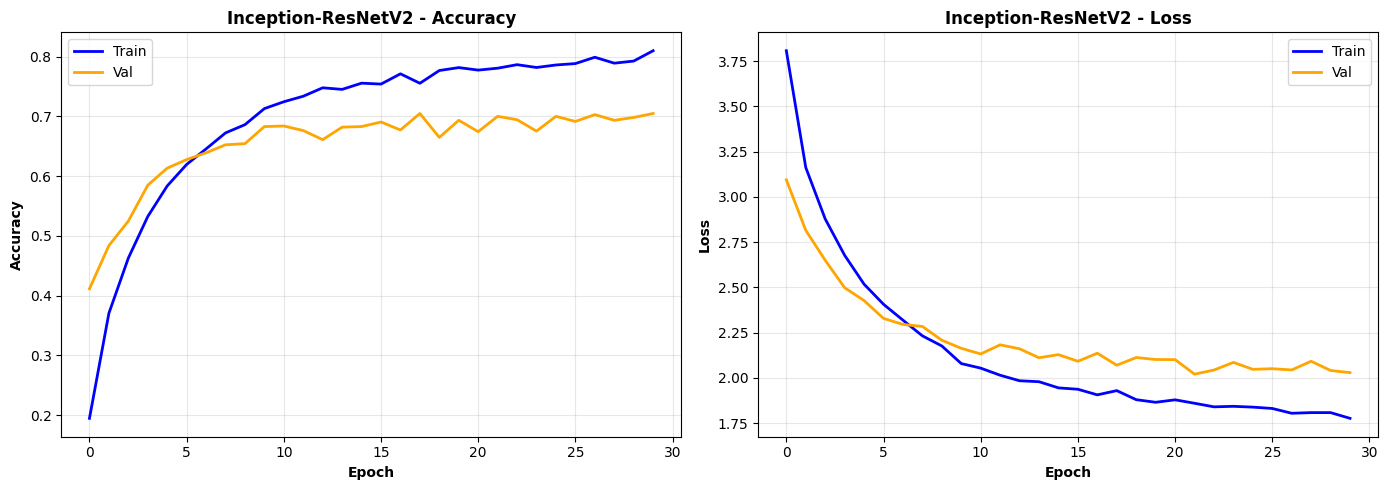

✅ Training Curves Kaydedildi!


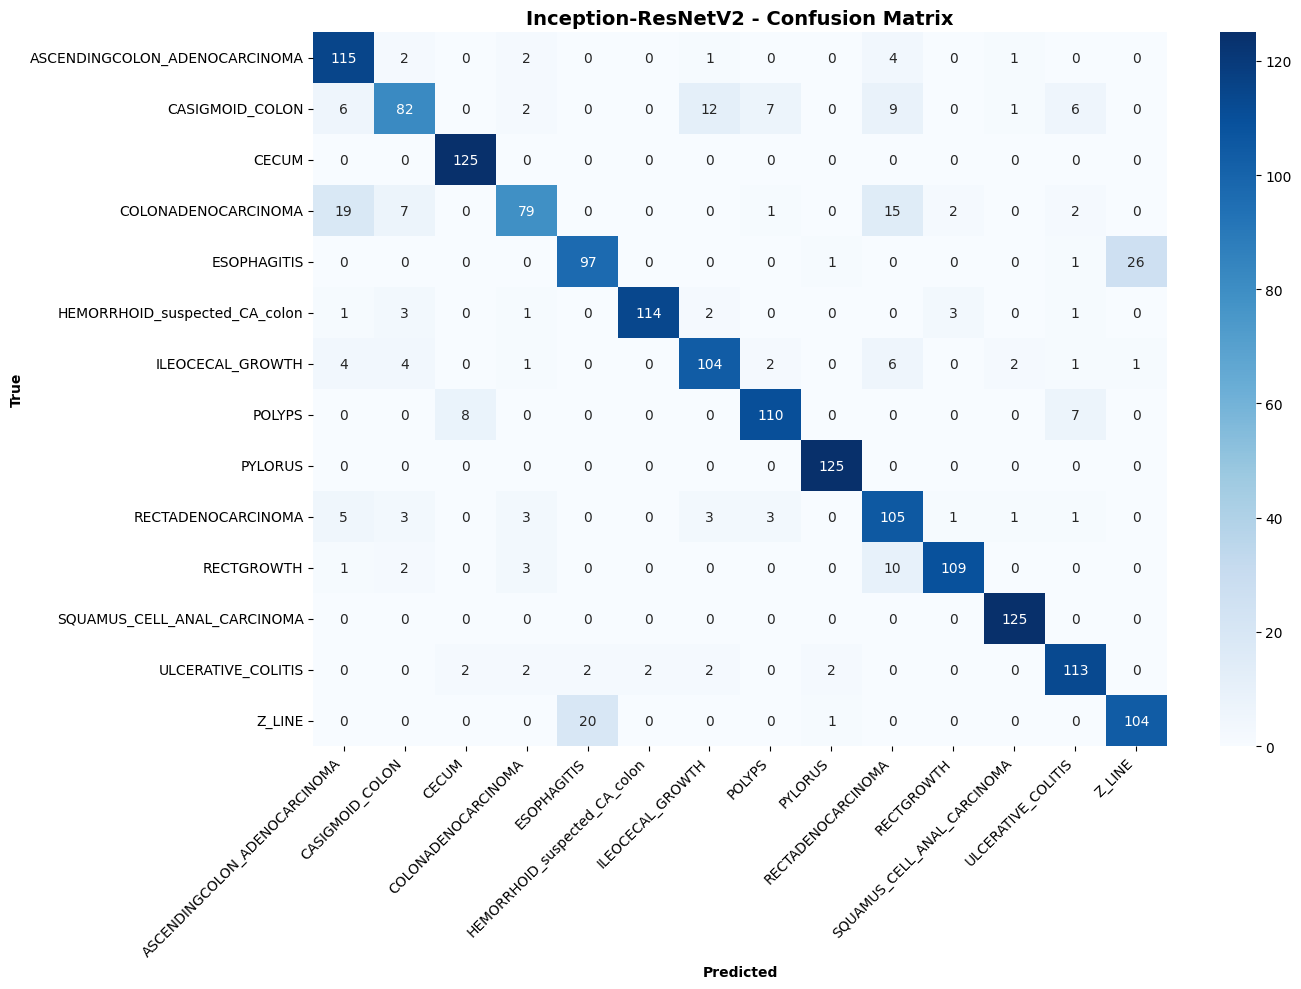

✅ Confusion Matrix Kaydedildi!


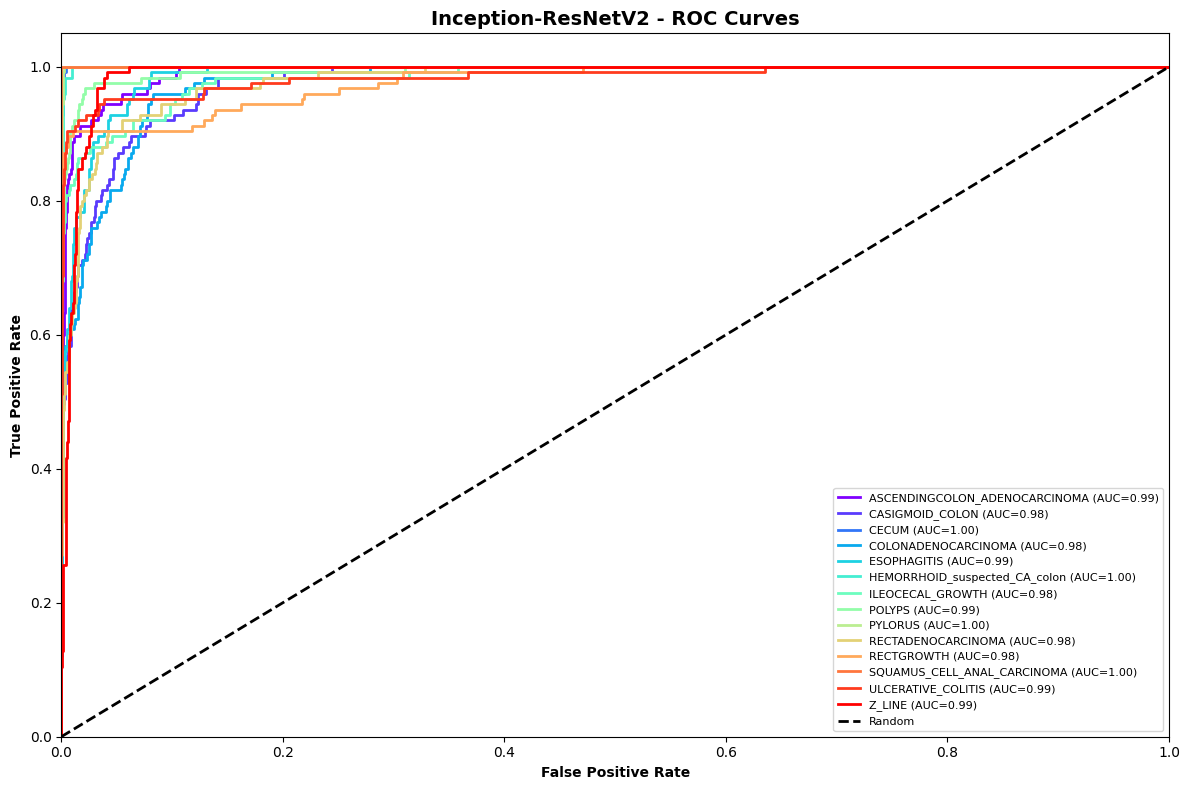

✅ ROC Eğrisi Kaydedildi!

📊 INCEPTION-RESNETV2 METRİKLERİ

✅ Inception-ResNetV2 Tamamlandı!
  Train: 80.97%
  Val:   70.48%
  Test:   86.11%
  Gap:   10.50%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     86.41%
│ Recall:        86.11%
│ F1-Score:      85.96%
│ Cohen Kappa:  0.8505

✅ Grafikleri Tamamlandı!


In [ ]:
# ===========================================
# INCEPTION-RESNETV2 - GRAFİKLER
# ===========================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

test_pred = inception_resnet.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(inception_resnet_history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(inception_resnet_history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Inception-ResNetV2 - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(inception_resnet_history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(inception_resnet_history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('Inception-ResNetV2 - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('Inception-ResNetV2 - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Inception-ResNetV2 - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/InceptionResNetV2_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 INCEPTION-RESNETV2 METRİKLERİ")
print("="*70)
print(f"\n✅ Inception-ResNetV2 Tamamlandı!")
print(f"  Train: 80.97%")
print(f"  Val:   70.48%")
print(f"  Test:  {test_accuracy*100:6.2f}%")
print(f"  Gap:   10.50%")
print("-" * 70)
print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n✅ Grafikleri Tamamlandı!")

In [ ]:
# ===========================================
# NASNETLARGE - TRANSFER LEARNING
# ===========================================
# NAS (Neural Architecture Search) ile otomatik tasarlanan büyük ağ
# Hem NASNetMobile'den daha derin hem de daha güçlü özellik çıkarır

def create_nasnetlarge_optimized():
    base_model = keras.applications.NASNetLarge(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = keras.Sequential([
        base_model,

        Dense(512, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    return model
# MODELİ OLUŞTUR
nasnetlarge = create_nasnetlarge_optimized()

def custom_lr_schedule(epoch):
    if epoch < 5:
        return 0.00005
    elif epoch < 10:
        return 0.00003
    elif epoch < 15:
        return 0.00001
    else:
        return 0.000005

lr_scheduler = keras.callbacks.LearningRateScheduler(custom_lr_schedule)
# MODELİ DERLEYİN
# ===========================================
# Derle = Optimizer, Loss Fonksiyonu ve Metrikleri belirle
nasnetlarge.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# CALLBACK'LER (Eğitimi otomatik kontrol et)
callbacks_list = [
    lr_scheduler,
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ), 
    # -------- 4. Model Kontrol Noktası (Model Checkpoint) --------
    # Eğitim sırasında en iyi performanslı modeli otomatik kaydet
    # Amaç: Eğitim sırasında en iyi ağırlıkları koruma
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

nasnetlarge_history = nasnetlarge.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks_list,
    verbose=1
)

nasnetlarge.save('/content/drive/MyDrive/CRCCD_Models/NASNetLarge_optimized.h5')

test_pred = nasnetlarge.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = nasnetlarge_history.history['accuracy'][-1]
final_val = nasnetlarge_history.history['val_accuracy'][-1]
gap = (final_train - final_val) * 100

print(f"\n✅ NASNetLarge Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {gap:.2f}%")

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.1267 - loss: 4.1921
Epoch 1: val_accuracy improved from -inf to 0.39048, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 354s 714ms/step - accuracy: 0.1269 - loss: 4.1913 - val_accuracy: 0.3905 - val_loss: 3.2244 - learning_rate: 5.0000e-05
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3417 - loss: 3.3912
Epoch 2: val_accuracy improved from 0.39048 to 0.46762, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 141s 379ms/step - accuracy: 0.3417 - loss: 3.3910 - val_accuracy: 0.4676 - val_loss: 2.9458 - learning_rate: 5.0000e-05
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4213 - loss: 3.1196
Epoch 3: val_accuracy improved from 0.46762 to 0.52000, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 146s 391ms/step - accuracy: 0.4214 - loss: 3.1194 - val_accuracy: 0.5200 - val_loss: 2.8271 - learning_rate: 5.0000e-05
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4869 - loss: 2.9214
Epoch 4: val_accuracy improved from 0.52000 to 0.53619, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 147s 394ms/step - accuracy: 0.4870 - loss: 2.9214 - val_accuracy: 0.5362 - val_loss: 2.7308 - learning_rate: 5.0000e-05
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5441 - loss: 2.7594
Epoch 5: val_accuracy improved from 0.53619 to 0.58667, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 146s 390ms/step - accuracy: 0.5441 - loss: 2.7594 - val_accuracy: 0.5867 - val_loss: 2.6169 - learning_rate: 5.0000e-05
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5753 - loss: 2.6497
Epoch 6: val_accuracy improved from 0.58667 to 0.59714, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 147s 394ms/step - accuracy: 0.5753 - loss: 2.6496 - val_accuracy: 0.5971 - val_loss: 2.5769 - learning_rate: 3.0000e-05
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5995 - loss: 2.5786
Epoch 7: val_accuracy did not improve from 0.59714
372/372 ━━━━━━━━━━━━━━━━━━━━ 139s 369ms/step - accuracy: 0.5995 - loss: 2.5786 - val_accuracy: 0.5800 - val_loss: 2.5749 - learning_rate: 3.0000e-05
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6109 - loss: 2.5010
Epoch 8: val_accuracy improved from 0.59714 to 0.60667, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 139s 373ms/step - accuracy: 0.6110 - loss: 2.5010 - val_accuracy: 0.6067 - val_loss: 2.5003 - learning_rate: 3.0000e-05
Epoch 9/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6283 - loss: 2.4529
Epoch 9: val_accuracy did not improve from 0.60667
372/372 ━━━━━━━━━━━━━━━━━━━━ 139s 373ms/step - accuracy: 0.6283 - loss: 2.4529 - val_accuracy: 0.6067 - val_loss: 2.5072 - learning_rate: 3.0000e-05
Epoch 10/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6514 - loss: 2.3841
Epoch 10: val_accuracy improved from 0.60667 to 0.61143, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 140s 377ms/step - accuracy: 0.6514 - loss: 2.3841 - val_accuracy: 0.6114 - val_loss: 2.4678 - learning_rate: 3.0000e-05
Epoch 11/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6628 - loss: 2.3394
Epoch 11: val_accuracy improved from 0.61143 to 0.61333, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 146s 393ms/step - accuracy: 0.6628 - loss: 2.3393 - val_accuracy: 0.6133 - val_loss: 2.4530 - learning_rate: 1.0000e-05
Epoch 12/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6791 - loss: 2.3012
Epoch 12: val_accuracy improved from 0.61333 to 0.63429, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 145s 386ms/step - accuracy: 0.6791 - loss: 2.3012 - val_accuracy: 0.6343 - val_loss: 2.4062 - learning_rate: 1.0000e-05
Epoch 13/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6721 - loss: 2.2992
Epoch 13: val_accuracy did not improve from 0.63429
372/372 ━━━━━━━━━━━━━━━━━━━━ 137s 369ms/step - accuracy: 0.6721 - loss: 2.2991 - val_accuracy: 0.6295 - val_loss: 2.4144 - learning_rate: 1.0000e-05
Epoch 14/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6817 - loss: 2.2840
Epoch 14: val_accuracy improved from 0.63429 to 0.63905, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 141s 379ms/step - accuracy: 0.6817 - loss: 2.2840 - val_accuracy: 0.6390 - val_loss: 2.4241 - learning_rate: 1.0000e-05
Epoch 15/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6900 - loss: 2.2418
Epoch 15: val_accuracy improved from 0.63905 to 0.64571, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 146s 389ms/step - accuracy: 0.6900 - loss: 2.2418 - val_accuracy: 0.6457 - val_loss: 2.3671 - learning_rate: 1.0000e-05
Epoch 16/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6880 - loss: 2.2471
Epoch 16: val_accuracy did not improve from 0.64571
372/372 ━━━━━━━━━━━━━━━━━━━━ 138s 370ms/step - accuracy: 0.6880 - loss: 2.2471 - val_accuracy: 0.6390 - val_loss: 2.3725 - learning_rate: 5.0000e-06
Epoch 17/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6994 - loss: 2.2102
Epoch 17: val_accuracy did not improve from 0.64571
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.6994 - loss: 2.2102 - val_accuracy: 0.6457 - val_loss: 2.3360 - learning_rate: 5.0000e-06
Epoch 18/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7010 - loss: 2.2129
Epoch 18: val_accuracy improved from 0.64571 to 0.65238, saving model to /content/drive/MyDrive/CRCCD_Models/NASNetLarge_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 140s 375ms/step - accuracy: 0.7010 - loss: 2.2128 - val_accuracy: 0.6524 - val_loss: 2.3496 - learning_rate: 5.0000e-06
Epoch 19/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7042 - loss: 2.1901
Epoch 19: val_accuracy did not improve from 0.65238
372/372 ━━━━━━━━━━━━━━━━━━━━ 139s 373ms/step - accuracy: 0.7042 - loss: 2.1901 - val_accuracy: 0.6295 - val_loss: 2.3611 - learning_rate: 5.0000e-06
Epoch 20/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6986 - loss: 2.2065
Epoch 20: val_accuracy did not improve from 0.65238
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.6986 - loss: 2.2065 - val_accuracy: 0.6400 - val_loss: 2.3641 - learning_rate: 5.0000e-06
Epoch 21/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7142 - loss: 2.1780
Epoch 21: val_accuracy did not improve from 0.65238
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.7142 - loss: 2.1780 - val_accuracy: 0.6438 - val_loss: 2.3219 - learnin

372/372 ━━━━━━━━━━━━━━━━━━━━ 140s 375ms/step - accuracy: 0.7297 - loss: 2.0830 - val_accuracy: 0.6562 - val_loss: 2.2888 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 30.


110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 543ms/step

✅ NASNetLarge Tamamlandı!
  Train: 72.97%
  Val:   65.62%
  Test:  79.09%
  Gap:   7.36%


110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step


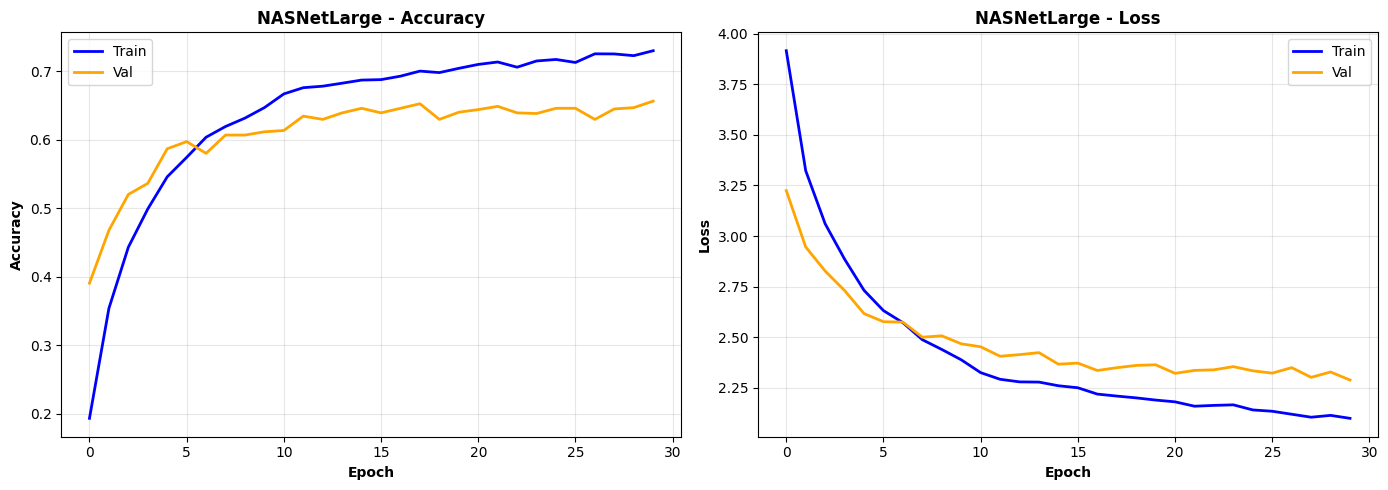

✅ Training Curves Kaydedildi!


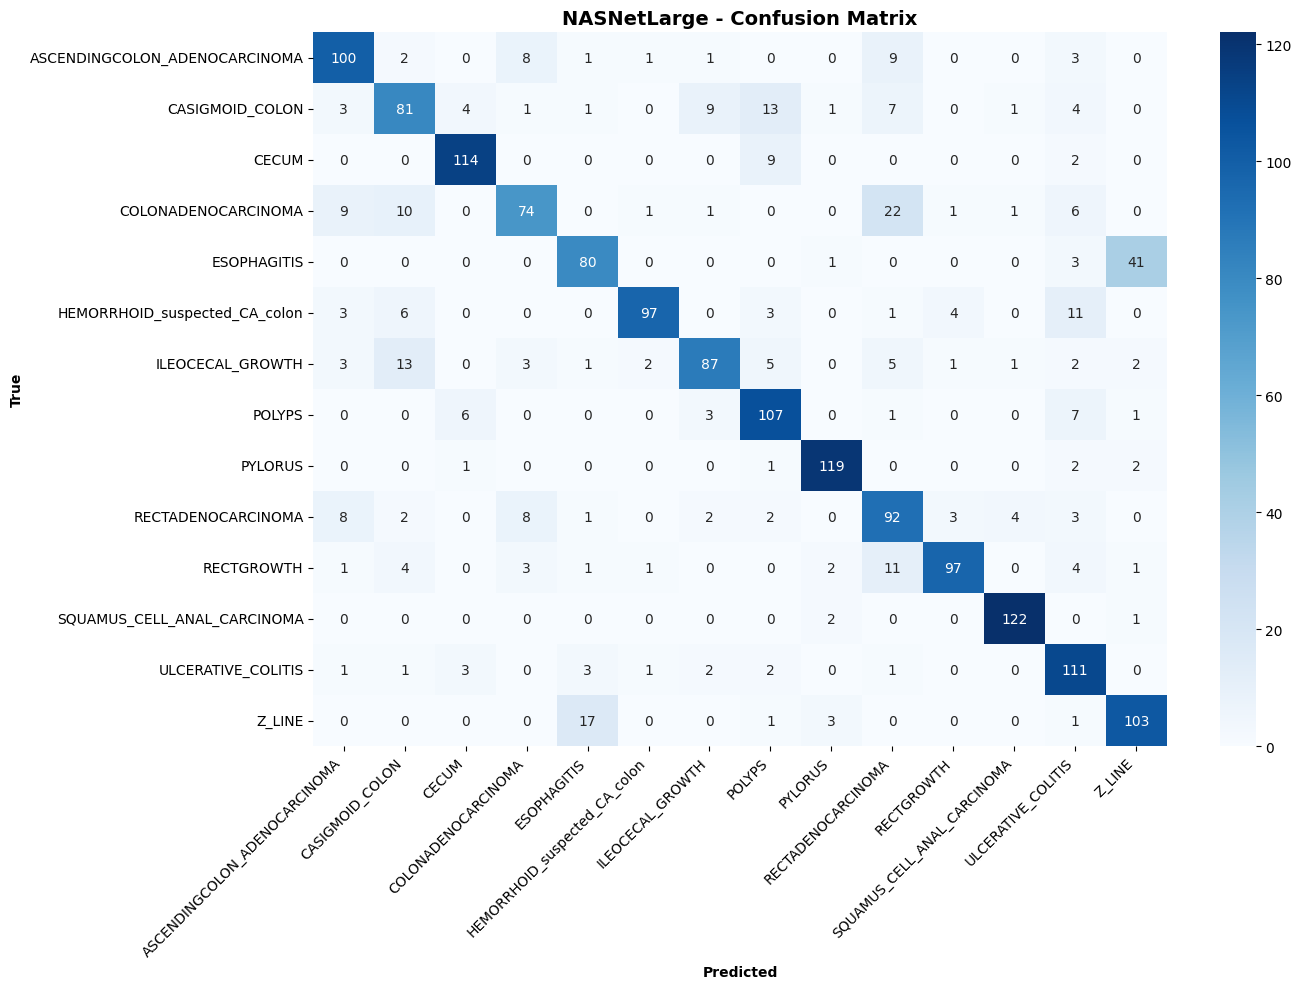

✅ Confusion Matrix Kaydedildi!


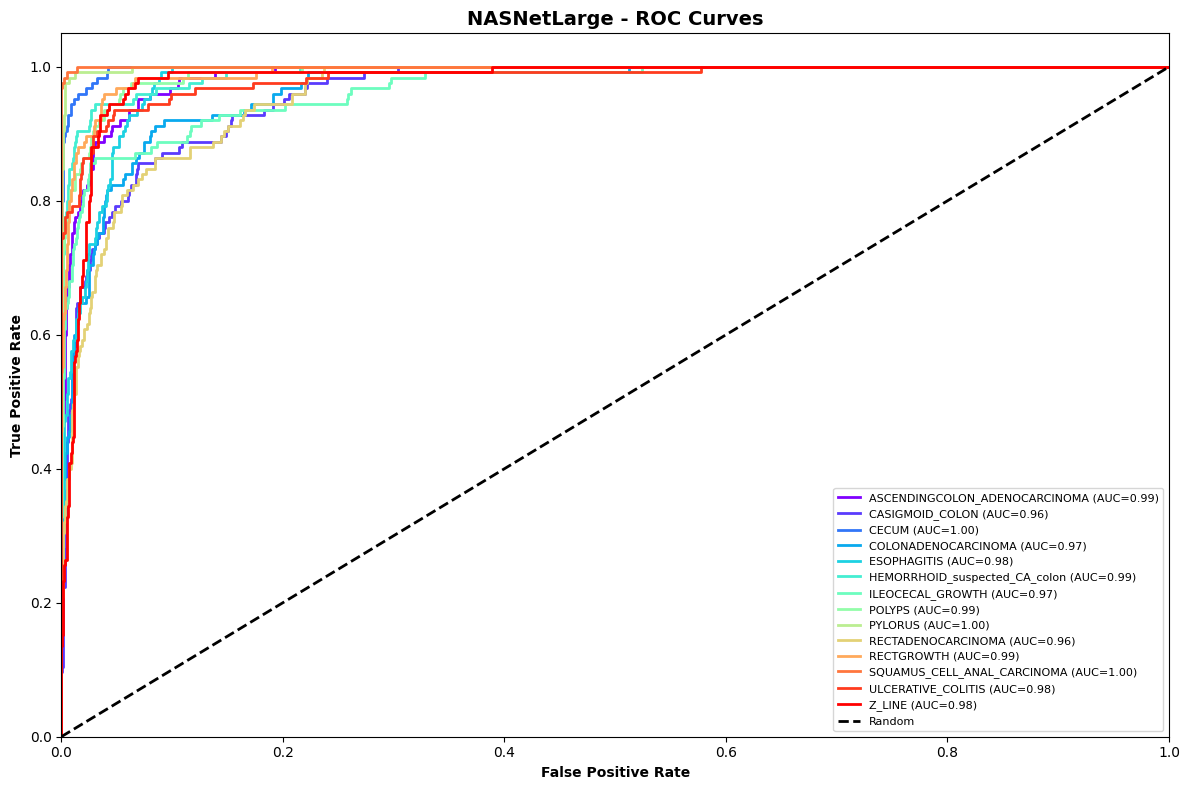

✅ ROC Eğrisi Kaydedildi!

📊 NASNETLARGE METRİKLERİ

✅ NASNetLarge Tamamlandı!
  Train: 72.97%
  Val:   65.62%
  Test:   79.09%
  Gap:   7.36%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     79.89%
│ Recall:        79.09%
│ F1-Score:      79.03%
│ Cohen Kappa:  0.7748

✅ Grafikleri Tamamlandı!


In [ ]:
# ===========================================
# NASNETLARGE - GRAFİKLER
# ===========================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

test_pred = nasnetlarge.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(nasnetlarge_history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(nasnetlarge_history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('NASNetLarge - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(nasnetlarge_history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(nasnetlarge_history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('NASNetLarge - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/NASNetLarge_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('NASNetLarge - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/NASNetLarge_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('NASNetLarge - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/NASNetLarge_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 NASNETLARGE METRİKLERİ")
print("="*70)
print(f"\n✅ NASNetLarge Tamamlandı!")
print(f"  Train: 72.97%")
print(f"  Val:   65.62%")
print(f"  Test:  {test_accuracy*100:6.2f}%")
print(f"  Gap:   7.36%")
print("-" * 70)
print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n✅ Grafikleri Tamamlandı!")

In [ ]:
# ===========================================
# CUSTOM CNN V3 - OPTIMIZED
# ===========================================
# Sıfırdan tasarlanan özel CNN mimarisi
# Transfer learning yerine scratch'ten başlar
# ImageNet önceden eğitilmiş ağlar yerine kendi öğrenmesi gerekir

def create_custom_cnn_v3_optimized():
    model = keras.Sequential([
        # BLOCK 1
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.2),

        # BLOCK 2
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.2),

        # BLOCK 3
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.3),

        # BLOCK 4
        keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.3),

        # GLOBAL POOLING
        keras.layers.GlobalAveragePooling2D(),

        # DENSE LAYERS
        keras.layers.Dense(512, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(256, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(128, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

custom_cnn_v3 = create_custom_cnn_v3_optimized()
# ÖZEL ÖĞRENİM ORANI PLANLAMASI
def custom_lr_schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    elif epoch < 15:
        return 0.0002
    else:
        return 0.0001

lr_scheduler = keras.callbacks.LearningRateScheduler(custom_lr_schedule)

custom_cnn_v3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# CALLBACK'LER
callbacks_list = [
    lr_scheduler,
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

custom_cnn_v3_history = custom_cnn_v3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks_list,
    verbose=1
)

custom_cnn_v3.save('/content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_optimized.h5')

test_pred = custom_cnn_v3.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_acc = np.sum(test_pred_classes == test_true) / len(test_true)

final_train = custom_cnn_v3_history.history['accuracy'][-1]
final_val = custom_cnn_v3_history.history['val_accuracy'][-1]
gap = (final_train - final_val) * 100

print(f"\n✅ Custom CNN V3 Tamamlandı!")
print(f"  Train: {final_train*100:.2f}%")
print(f"  Val:   {final_val*100:.2f}%")
print(f"  Test:  {test_acc*100:.2f}%")
print(f"  Gap:   {gap:.2f}%")

Epoch 1/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.1959 - loss: 3.4559
Epoch 1: val_accuracy improved from -inf to 0.06190, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 163s 391ms/step - accuracy: 0.1960 - loss: 3.4552 - val_accuracy: 0.0619 - val_loss: 4.4987 - learning_rate: 0.0010
Epoch 2/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.2936 - loss: 2.7663
Epoch 2: val_accuracy improved from 0.06190 to 0.09048, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.2936 - loss: 2.7661 - val_accuracy: 0.0905 - val_loss: 4.1457 - learning_rate: 0.0010
Epoch 3/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3549 - loss: 2.4193
Epoch 3: val_accuracy improved from 0.09048 to 0.23524, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 355ms/step - accuracy: 0.3549 - loss: 2.4191 - val_accuracy: 0.2352 - val_loss: 2.9586 - learning_rate: 0.0010
Epoch 4/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3880 - loss: 2.1319
Epoch 4: val_accuracy did not improve from 0.23524
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.3880 - loss: 2.1319 - val_accuracy: 0.2248 - val_loss: 2.8772 - learning_rate: 0.0010
Epoch 5/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.3997 - loss: 2.0023
Epoch 5: val_accuracy did not improve from 0.23524
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.3997 - loss: 2.0023 - val_accuracy: 0.2267 - val_loss: 2.9230 - learning_rate: 0.0010
Epoch 6/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4254 - loss: 1.8547
Epoch 6: val_accuracy improved from 0.23524 to 0.27905, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 353ms/step - accuracy: 0.4254 - loss: 1.8545 - val_accuracy: 0.2790 - val_loss: 2.2937 - learning_rate: 5.0000e-04
Epoch 7/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.4572 - loss: 1.7362
Epoch 7: val_accuracy improved from 0.27905 to 0.40667, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.4572 - loss: 1.7361 - val_accuracy: 0.4067 - val_loss: 1.7778 - learning_rate: 5.0000e-04
Epoch 8/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.4504 - loss: 1.6773
Epoch 8: val_accuracy improved from 0.40667 to 0.44000, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.4505 - loss: 1.6772 - val_accuracy: 0.4400 - val_loss: 1.7593 - learning_rate: 5.0000e-04
Epoch 9/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4796 - loss: 1.6219
Epoch 9: val_accuracy did not improve from 0.44000
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - accuracy: 0.4796 - loss: 1.6219 - val_accuracy: 0.4029 - val_loss: 1.8722 - learning_rate: 5.0000e-04
Epoch 10/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4833 - loss: 1.5655
Epoch 10: val_accuracy improved from 0.44000 to 0.44476, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.4833 - loss: 1.5655 - val_accuracy: 0.4448 - val_loss: 1.6586 - learning_rate: 5.0000e-04
Epoch 11/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4985 - loss: 1.5085
Epoch 11: val_accuracy did not improve from 0.44476
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.4985 - loss: 1.5085 - val_accuracy: 0.3962 - val_loss: 1.9284 - learning_rate: 2.0000e-04
Epoch 12/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5093 - loss: 1.4632
Epoch 12: val_accuracy improved from 0.44476 to 0.48190, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.5094 - loss: 1.4632 - val_accuracy: 0.4819 - val_loss: 1.5425 - learning_rate: 2.0000e-04
Epoch 13/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5204 - loss: 1.4099
Epoch 13: val_accuracy did not improve from 0.48190
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.5204 - loss: 1.4099 - val_accuracy: 0.4810 - val_loss: 1.6008 - learning_rate: 2.0000e-04
Epoch 14/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5173 - loss: 1.3941
Epoch 14: val_accuracy did not improve from 0.48190
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.5174 - loss: 1.3940 - val_accuracy: 0.4619 - val_loss: 1.5736 - learning_rate: 2.0000e-04
Epoch 15/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5426 - loss: 1.3590
Epoch 15: val_accuracy did not improve from 0.48190
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 348ms/step - accuracy: 0.5426 - loss: 1.3590 - val_accuracy: 0.4743 - val_loss: 1.5301 - learnin

372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.5721 - loss: 1.3058 - val_accuracy: 0.5010 - val_loss: 1.4983 - learning_rate: 1.0000e-04
Epoch 17/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5679 - loss: 1.2756
Epoch 17: val_accuracy improved from 0.50095 to 0.52286, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.5679 - loss: 1.2755 - val_accuracy: 0.5229 - val_loss: 1.4131 - learning_rate: 1.0000e-04
Epoch 18/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5752 - loss: 1.2552
Epoch 18: val_accuracy did not improve from 0.52286
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.5752 - loss: 1.2552 - val_accuracy: 0.4943 - val_loss: 1.4713 - learning_rate: 1.0000e-04
Epoch 19/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5697 - loss: 1.2421
Epoch 19: val_accuracy improved from 0.52286 to 0.53143, saving model to /content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_best.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.5697 - loss: 1.2421 - val_accuracy: 0.5314 - val_loss: 1.3972 - learning_rate: 1.0000e-04
Epoch 20/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5895 - loss: 1.2072
Epoch 20: val_accuracy did not improve from 0.53143
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 352ms/step - accuracy: 0.5895 - loss: 1.2073 - val_accuracy: 0.5076 - val_loss: 1.4787 - learning_rate: 1.0000e-04
Epoch 21/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5771 - loss: 1.2259
Epoch 21: val_accuracy did not improve from 0.53143
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.5772 - loss: 1.2258 - val_accuracy: 0.5314 - val_loss: 1.4434 - learning_rate: 1.0000e-04
Epoch 22/25
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6006 - loss: 1.1879
Epoch 22: val_accuracy did not improve from 0.53143
372/372 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.6005 - loss: 1.1879 - val_accuracy: 0.5124 - val_loss: 1.4169 - learnin

110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step

✅ Custom CNN V3 Tamamlandı!
  Train: 61.29%
  Val:   53.05%
  Test:  66.57%
  Gap:   8.25%


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step


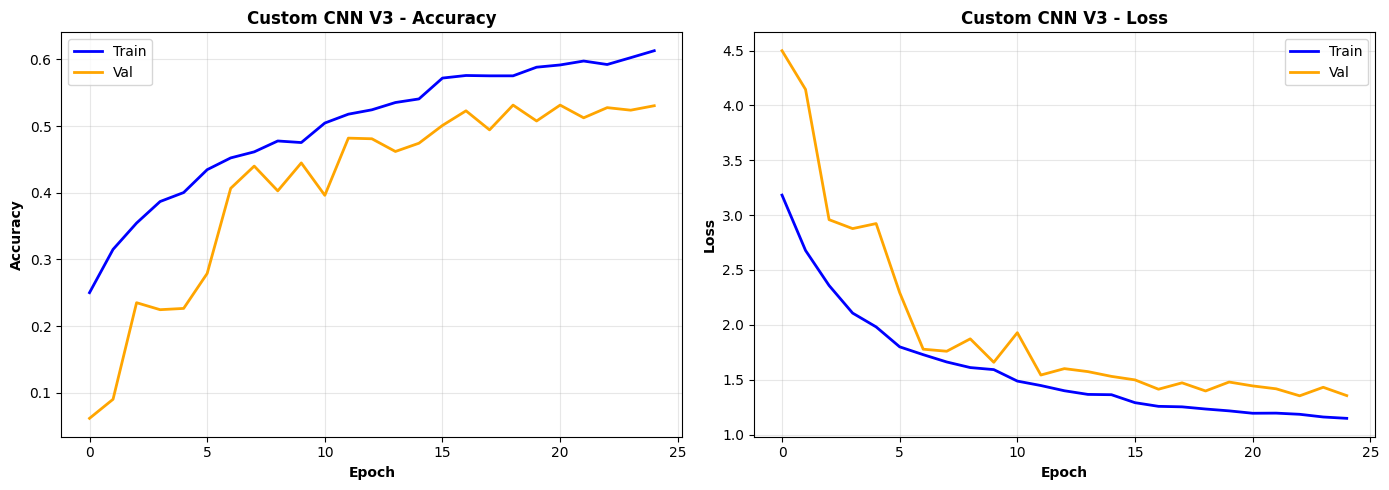

✅ Training Curves Kaydedildi!


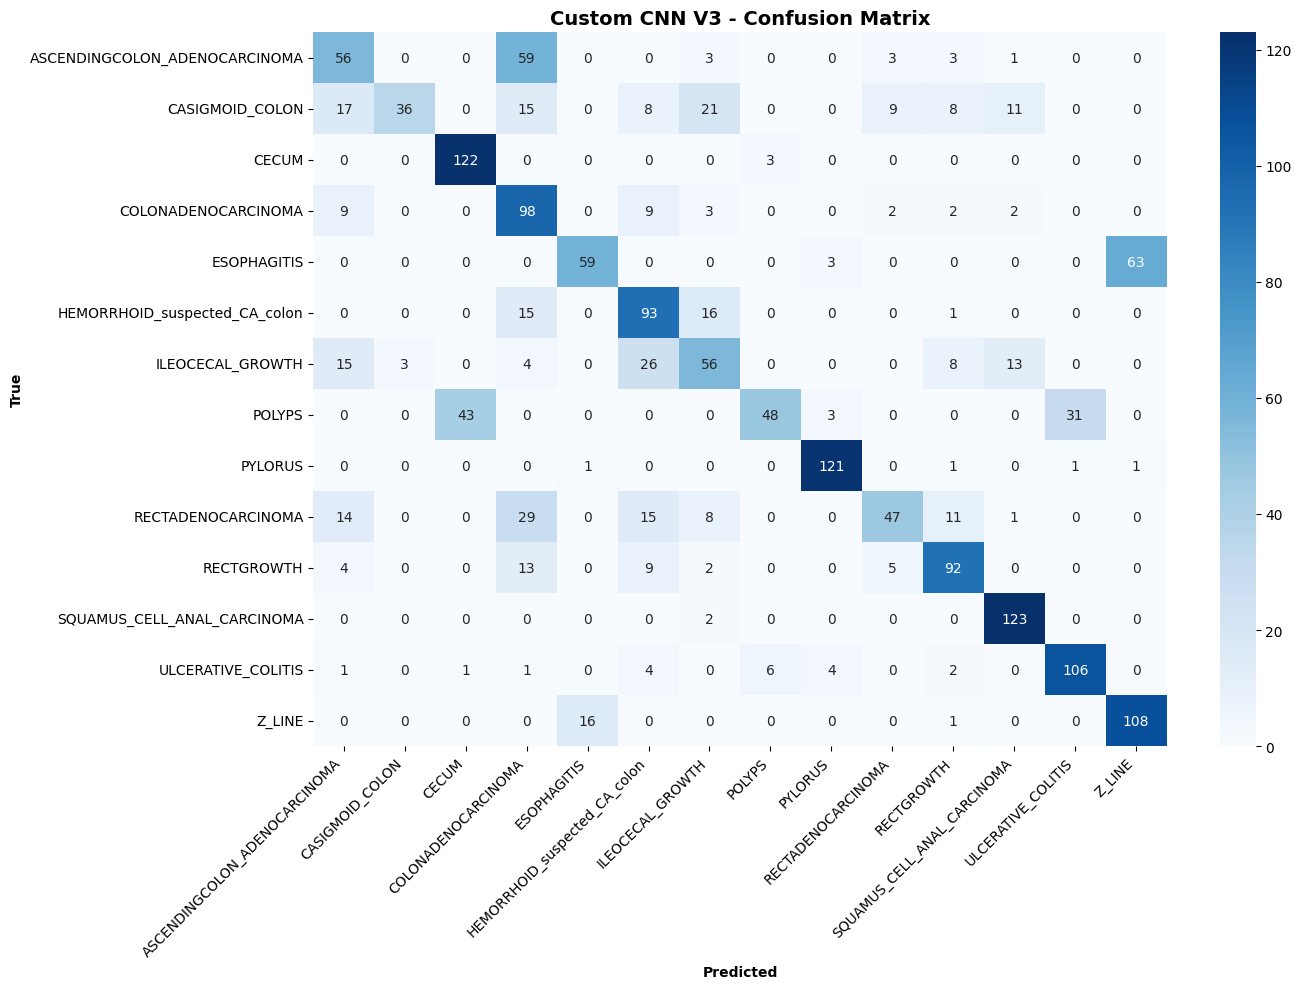

✅ Confusion Matrix Kaydedildi!


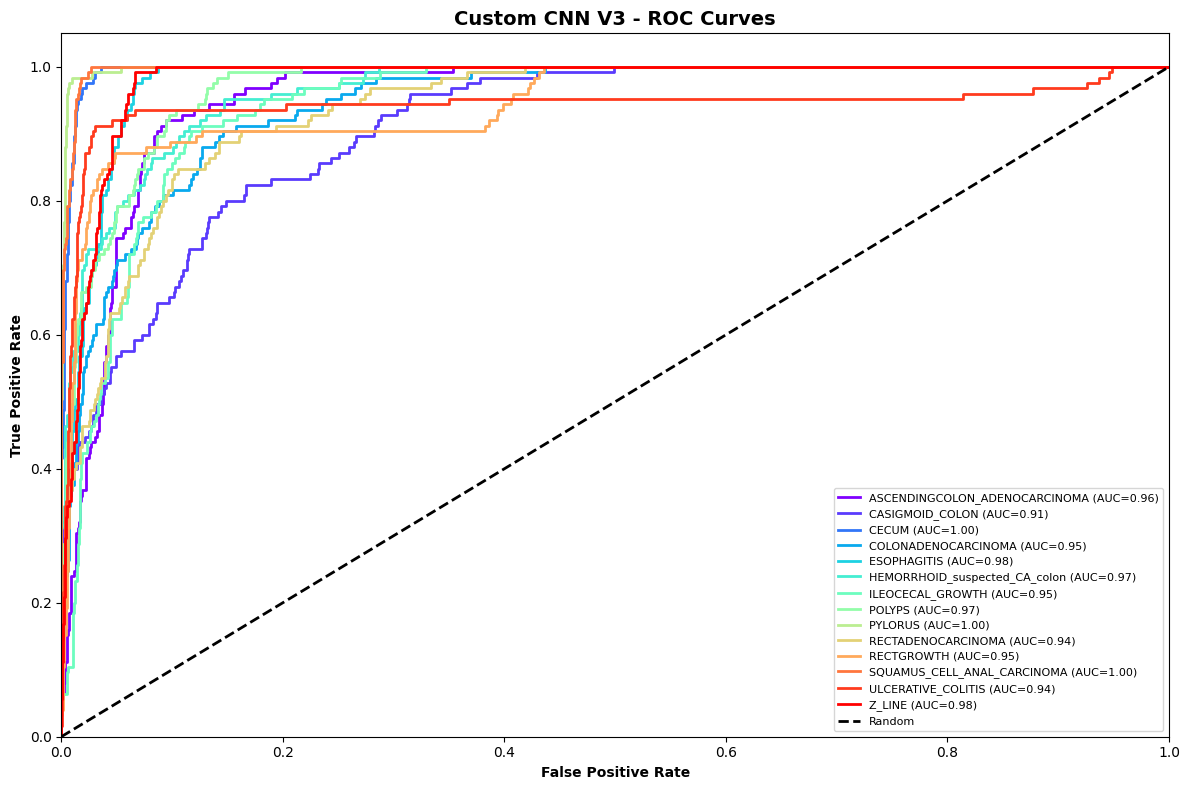

✅ ROC Eğrisi Kaydedildi!

📊 CUSTOM CNN V3 METRİKLERİ

✅ Custom CNN V3 Tamamlandı!
  Train: 61.29%
  Val:   53.05%
  Test:   66.57%
  Gap:   8.25%
----------------------------------------------------------------------

📊 DETAYLI METRİKLER:
│ Precision:     70.07%
│ Recall:        66.57%
│ F1-Score:      65.05%
│ Cohen Kappa:  0.6400

✅ Custom CNN V3 Grafikleri Tamamlandı!


In [ ]:
# ===========================================
# CUSTOM CNN V3 - GRAFİKLER
# ===========================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import label_binarize

test_pred = custom_cnn_v3.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true = test_generator.classes
test_accuracy = np.sum(test_pred_classes == test_true) / len(test_true)

# 1. TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(custom_cnn_v3_history.history['accuracy'], label='Train', linewidth=2, color='blue')
axes[0].plot(custom_cnn_v3_history.history['val_accuracy'], label='Val', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Custom CNN V3 - Accuracy', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(custom_cnn_v3_history.history['loss'], label='Train', linewidth=2, color='blue')
axes[1].plot(custom_cnn_v3_history.history['val_loss'], label='Val', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('Custom CNN V3 - Loss', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_TrainingCurves.png', dpi=150)
plt.show()
print("✅ Training Curves Kaydedildi!")

# 2. CONFUSION MATRIX
cm = confusion_matrix(test_true, test_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('Custom CNN V3 - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_ConfusionMatrix.png', dpi=150)
plt.show()
print("✅ Confusion Matrix Kaydedildi!")

# 3. ROC EĞRİSİ
y_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Custom CNN V3 - ROC Curves', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/CustomCNN_V3_ROC.png', dpi=150)
plt.show()
print("✅ ROC Eğrisi Kaydedildi!")

precision = precision_score(test_true, test_pred_classes, average='weighted')
recall = recall_score(test_true, test_pred_classes, average='weighted')
f1 = f1_score(test_true, test_pred_classes, average='weighted')
kappa = cohen_kappa_score(test_true, test_pred_classes)

print(f"\n" + "="*70)
print("📊 CUSTOM CNN V3 METRİKLERİ")
print("="*70)
print(f"\n✅ Custom CNN V3 Tamamlandı!")
print(f"  Train: 61.29%")
print(f"  Val:   53.05%")
print(f"  Test:  {test_accuracy*100:6.2f}%")
print(f"  Gap:   8.25%")
print("-" * 70)
print(f"\n📊 DETAYLI METRİKLER:")
print(f"│ Precision:    {precision*100:6.2f}%")
print(f"│ Recall:       {recall*100:6.2f}%")
print(f"│ F1-Score:     {f1*100:6.2f}%")
print(f"│ Cohen Kappa:  {kappa:6.4f}")
print("="*70)

print(f"\n✅ Custom CNN V3 Grafikleri Tamamlandı!")

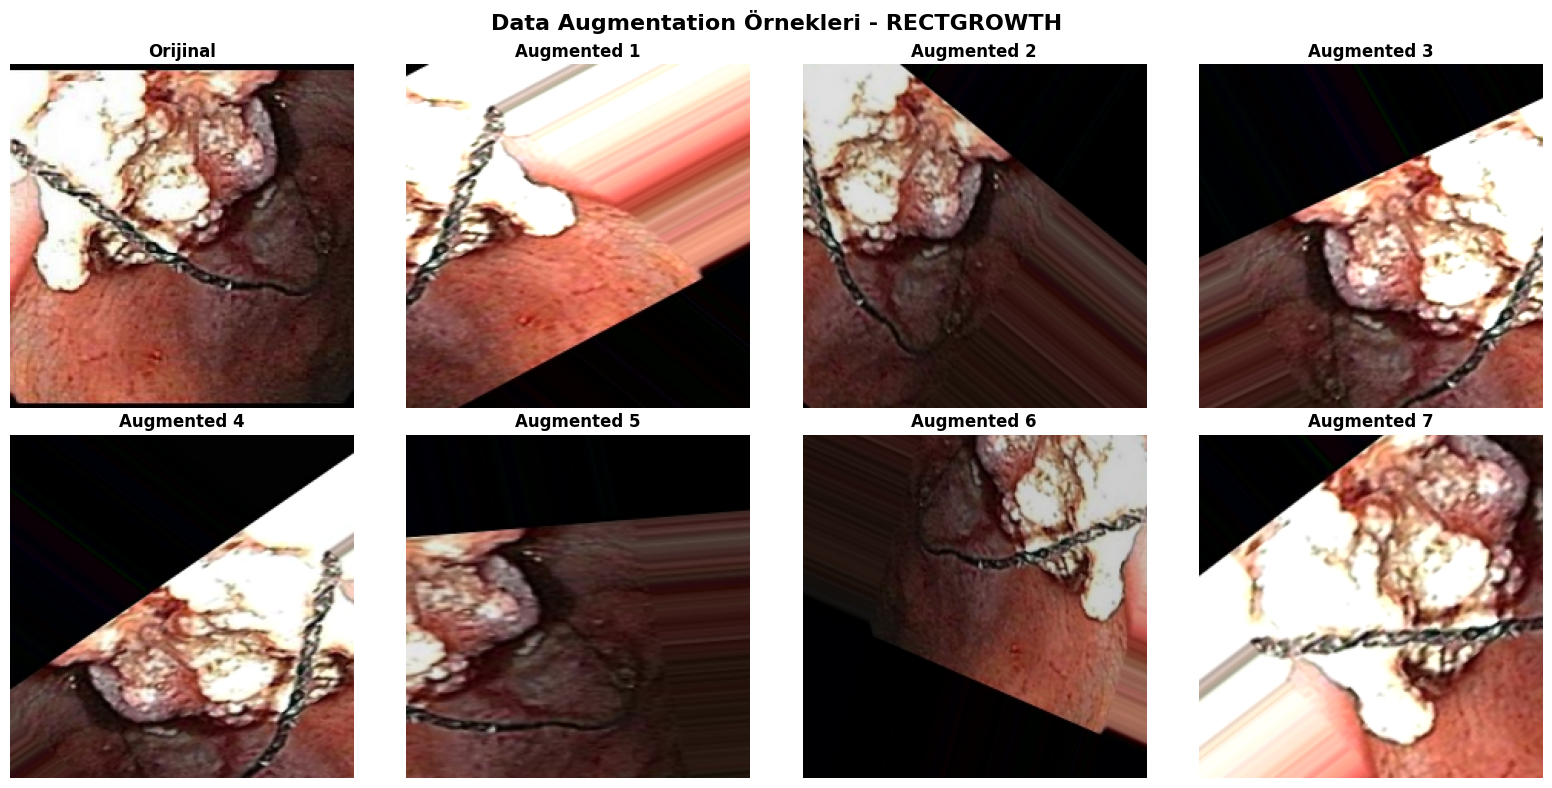

✅ Data Augmentation Görseli Kaydedildi!
   Sınıf: RECTGROWTH
   Konum: /content/drive/MyDrive/CRCCD_Models/Data_Augmentation_Ornegi.png


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Augmentation Generator
augmentation_generator = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Test set'ten rastgele bir görüntü seç
test_class = np.random.choice(classes)
test_path = f'{test_dir}/{test_class}'
test_images = os.listdir(test_path)
test_image_name = np.random.choice(test_images)
test_image_path = f'{test_path}/{test_image_name}'

# Görüntüyü yükle
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Augmented versiyonlar oluştur
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle(f'Data Augmentation Örnekleri - {test_class}', fontsize=16, fontweight='bold')

# Orijinal
axes[0, 0].imshow(img_array[0].astype('uint8'))
axes[0, 0].set_title('Orijinal', fontweight='bold')
axes[0, 0].axis('off')

# 7 Augmented versiyon
for i, ax in enumerate([(0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]):
    augmented_img = augmentation_generator.random_transform(img_array[0])
    augmented_img = np.clip(augmented_img, 0, 255).astype('uint8')

    axes[ax].imshow(augmented_img)
    axes[ax].set_title(f'Augmented {i+1}', fontweight='bold')
    axes[ax].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CRCCD_Models/Data_Augmentation_Ornegi.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Data Augmentation Görseli Kaydedildi!")
print(f"   Sınıf: {test_class}")
print(f"   Konum: /content/drive/MyDrive/CRCCD_Models/Data_Augmentation_Ornegi.png")

Found 1750 images belonging to 14 classes.
📸 Örnekler seçiliyor ...


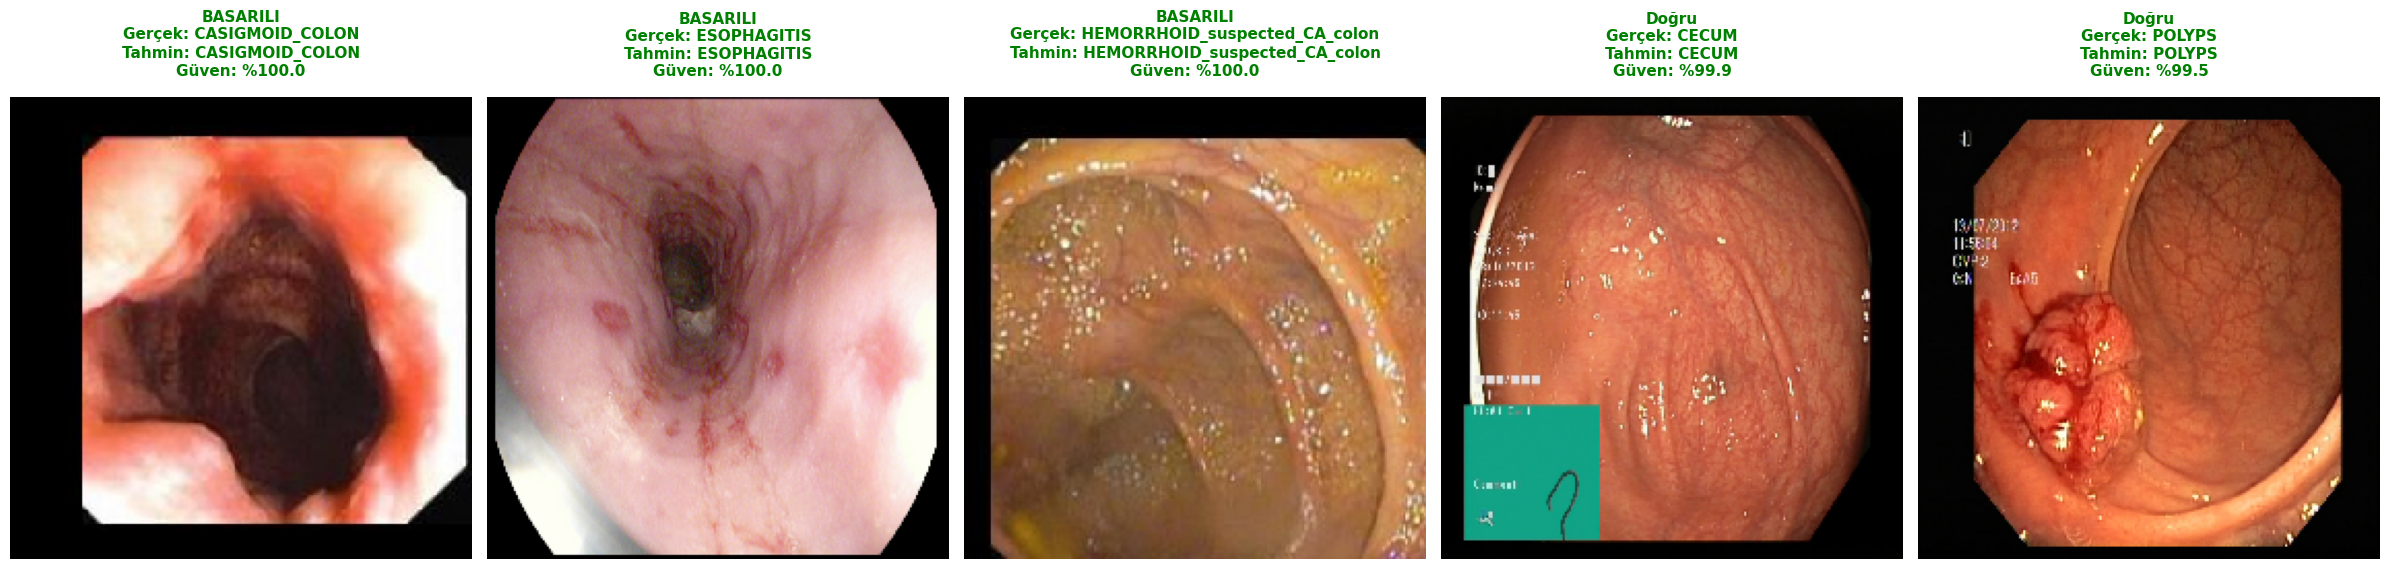

✅.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ============================================
# 1. AYARLAR
# ============================================
dataset_path = "/content/drive/MyDrive/CRCCD_V1 (Colorectal Cancer Classification and Detection)/CRCCD_V1"
test_dir = os.path.join(dataset_path, "Test")
model_path = '/content/drive/MyDrive/CRCCD_Models/DenseNet201_optimized.h5'

# ============================================
# 2. MODEL VE VERİ HAZIRLIĞI
# ============================================
if 'final_model' not in locals():
    print("🔄 Model Yükleniyor...")
    final_model = load_model(model_path)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32, # Büyük batch alalım ki seçenek çok olsun
    class_mode='categorical',
    shuffle=True
)
class_names = list(test_generator.class_indices.keys())

# ============================================
# 3. ÖRNEKLERİ TOPLAMA
# ============================================
print("📸 Örnekler seçiliyor ...")

guaranteed_correct = []
random_samples = []

# Generator'dan veri çek
images, labels = next(test_generator)

for i in range(len(images)):
    # Yeterli sayıya ulaştıysak döngüyü kır
    if len(guaranteed_correct) >= 3 and len(random_samples) >= 2:
        break

    img = images[i]
    true_idx = np.argmax(labels[i])
    true_label = class_names[true_idx]

    # Tahmin Yap
    img_input = np.expand_dims(img, axis=0)
    prediction = final_model.predict(img_input, verbose=0)
    pred_idx = np.argmax(prediction[0])
    pred_label = class_names[pred_idx]
    confidence = np.max(prediction[0]) * 100

    # Kriterlere Göre Listelere Ekle


    if len(guaranteed_correct) < 3:
        if true_label == pred_label and confidence > 85:
            guaranteed_correct.append((img, true_label, pred_label, confidence, True))
            continue # Bu resmi aldık, diğer listeye girmesin

    if len(guaranteed_correct) == 3 and len(random_samples) < 2:
        is_correct = (true_label == pred_label)
        random_samples.append((img, true_label, pred_label, confidence, is_correct))


final_showcase = guaranteed_correct + random_samples

# ============================================
# 4. ÇİZİM (VISUALIZATION)
# ============================================
plt.figure(figsize=(24, 7))

for i, item in enumerate(final_showcase):
    img, true_lbl, pred_lbl, conf, correct = item

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Renk ve Başlık Ayarı
    if correct:
        color = 'green'
        status = "BASARILI"

        if i >= 3: status = "Doğru"
    else:
        color = 'red'
        status = "HATALI "

    title_text = f"{status}\nGerçek: {true_lbl}\nTahmin: {pred_lbl}\nGüven: %{conf:.1f}"

    plt.title(title_text, color=color, fontsize=11, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()
print("✅.")